# 相対測光

## おまじない

In [5]:
import glob
from astropy.io import fits
from astropy.time import Time
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
import numpy as np
import matplotlib.pyplot as plt
from zoneinfo import ZoneInfo
from datetime import timezone
import pandas as pd
import matplotlib.dates as mdates

c:\Users\ohrtt\Desktop\c3_2024\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 重心座標検出定義

In [6]:
def find_star_position(data, initial_pos, search_radius, fwhm=3.0, threshold=5.0):
    """
    初期位置近辺で星を検出し、正確な座標と検出された星の情報を返す関数
    """
    # 背景ノイズの推定
    bkg_sigma = mad_std(data)
    
    # 星の検出
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold * bkg_sigma)
    sources = daofind(data - np.median(data))
    
    if sources is None or len(sources) == 0:
        print(f"No sources found around position {initial_pos}")
        return initial_pos, None  # 検出できなかった場合は初期位置とNoneを返す
    
    # 初期位置からの距離を計算
    distances = np.sqrt((sources['xcentroid'] - initial_pos[0])**2 + 
                        (sources['ycentroid'] - initial_pos[1])**2)
    
    # 検出範囲内の星をフィルタ
    within_radius = distances < search_radius
    if not np.any(within_radius):
        print(f"No sources within {search_radius}px of position {initial_pos}")
        return initial_pos, None  # 見つからない場合は初期位置とNoneを返す
    
    # 検出された星の中で最も明るいものを選択
    brightest = sources[within_radius][sources['flux'][within_radius].argmax()]
    
    return (brightest['xcentroid'], brightest['ycentroid']), brightest

## 測光定義

In [7]:
def process_fits_files(fits_files, target_initial, comp_initials, comp_fluxes_list,
                      times, rel_mags, target_mags, errors,
                      search_radius=15, aperture_scale=1.5, 
                      annulus_r_in=1, annulus_r_out=4, debug=False):
    """
    FITSファイルを処理して、ターゲット星と比較星のフラックスおよび機械等級を計算する関数。

    Parameters:
    - fits_files (list): 処理するFITSファイルのリスト。
    - target_initial (tuple): ターゲット星の初期位置 (x, y)。
    - comp_initials (list of tuples): 比較星の初期位置のリスト [(x1, y1), (x2, y2), ...]。
    - comp_fluxes_list (list of lists): 各比較星のフラックスを保存するリスト（外部で定義）。
    - times (list): 観測時刻を保存するリスト（外部で定義）。
    - rel_mags (list): 相対等級を保存するリスト（外部で定義）。
    - target_mags (list): ターゲット星の機械等級を保存するリスト（外部で定義）。
    - errors (list): 誤差を保存するリスト（外部で定義）。
    - search_radius (int): 星の検索半径（ピクセル単位）。
    - aperture_scale (float): FWHMに対するアパーチャのスケールファクター。
    - annulus_r_in (int): アノラスの内半径（アパーチャ半径に対するオフセット）。
    - annulus_r_out (int): アノラスの外半径（アパーチャ半径に対するオフセット）。
    - debug (bool): デバッグ用の詳細な出力を表示するかどうか。

    Returns:
    - None
    """
    # ターゲット星と比較星の現在の位置
    target_position = target_initial
    comp_positions = comp_initials.copy()
    
    # タイムゾーンの設定
    jst = ZoneInfo('Asia/Tokyo')
    
    # 各画像での処理
    for idx, file in enumerate(fits_files):
        if debug:
            print(f"Processing {file} ({idx+1}/{len(fits_files)})")
        try:
            with fits.open(file) as hdu:
                data = hdu[0].data
                header = hdu[0].header
        except Exception as e:
            if debug:
                print(f"Error opening {file}: {e}")
            for flux_list in comp_fluxes_list:
                flux_list.append(np.nan)
            target_mags.append(np.nan)
            rel_mags.append(np.nan)
            errors.append(np.nan)
            continue
        
        # 観測時刻を取得
        if 'DATE-OBS' in header:
            try:
                time_utc = Time(header['DATE-OBS']).to_datetime(timezone=timezone.utc)
                time_jst = time_utc.astimezone(jst)
            except Exception as e:
                if debug:
                    print(f"Error converting time for {file}: {e}")
                times.append(np.nan)
                for flux_list in comp_fluxes_list:
                    flux_list.append(np.nan)
                target_mags.append(np.nan)
                rel_mags.append(np.nan)
                errors.append(np.nan)
                continue
        else:
            if debug:
                print(f"DATE-OBS not found in {file}. Skipping.")
            times.append(np.nan)
            for flux_list in comp_fluxes_list:
                flux_list.append(np.nan)
            target_mags.append(np.nan)
            rel_mags.append(np.nan)
            errors.append(np.nan)
            continue
        times.append(time_jst)
        
        # ターゲット星の位置と明るい星の情報を取得
        target_position, brightest_star = find_star_position(data, target_position, search_radius=search_radius)
        
        # FWHMの取得
        if brightest_star is not None and 'fwhm' in brightest_star:
            measured_fwhm = brightest_star['fwhm']
            aperture_radius = measured_fwhm * aperture_scale  # FWHMのスケール倍をアパーチャ半径とする
        else:
            aperture_radius = 6  # デフォルト値
        
        # 参照星の位置を検索
        for i, comp_pos in enumerate(comp_positions):
            comp_positions[i], _ = find_star_position(data, comp_pos, search_radius=search_radius)
        
        # 測光アパーチャーを定義（動的に設定した半径を使用）
        positions = [target_position] + comp_positions
        apertures = CircularAperture(positions, r=aperture_radius)
        
        # アパーチャで測光を実行
        try:
            phot_table_apertures = aperture_photometry(data, apertures)
        except ValueError as ve:
            if debug:
                print(f"Aperture photometry error in {file}: {ve}")
            for flux_list in comp_fluxes_list:
                flux_list.append(np.nan)
            target_mags.append(np.nan)
            rel_mags.append(np.nan)
            errors.append(np.nan)
            continue
        
        # 背景補正用アノラスを定義（各アパーチャに対して一つのアノラスを作成）
        annuli = [CircularAnnulus(pos, r_in=aperture_radius + annulus_r_in, r_out=aperture_radius + annulus_r_out) for pos in positions]
        
        # アノラスで測光を実行
        try:
            phot_table_annuli = aperture_photometry(data, annuli)
        except ValueError as ve:
            if debug:
                print(f"Aperture photometry error for annuli in {file}: {ve}")
            for flux_list in comp_fluxes_list:
                flux_list.append(np.nan)
            target_mags.append(np.nan)
            rel_mags.append(np.nan)
            errors.append(np.nan)
            continue
        
        # 各アパーチャに対応するアノラスのフラックスを取得
        bkg_fluxes = []
        num_apertures = len(apertures)
        for i in range(num_apertures):
            annulus_flux = phot_table_annuli['aperture_sum'][i]
            bkg_area = annuli[i].area
            if bkg_area == 0:
                if debug:
                    print(f"Annulus area is zero for aperture {i+1} in {file}. Setting background flux to 0.")
                bkg_per_pixel = 0
            else:
                bkg_per_pixel = annulus_flux / bkg_area  # 1ピクセルあたりの背景フラックス
            apertures_area = apertures.area[i]  # 各アパーチャの面積
            bkg_total = bkg_per_pixel * apertures_area  # アパーチャ内の総背景フラックス
            bkg_fluxes.append(bkg_total)
        
        # アパーチャ内の背景を差し引いたフラックスを計算
        target_flux = phot_table_apertures['aperture_sum'][0] - bkg_fluxes[0]
        comp_fluxes = phot_table_apertures['aperture_sum'][1:] - np.array(bkg_fluxes[1:])
        
        # フラックスが負になる場合は np.nan に設定
        target_flux = target_flux if target_flux > 0 else np.nan
        comp_fluxes = np.where(comp_fluxes > 0, comp_fluxes, np.nan)
        
        # 相対等級を計算
        if not np.isnan(target_flux) and not np.isnan(comp_fluxes).all():
            comp_flux = np.nanmean(comp_fluxes)
            if comp_flux > 0:
                rel_mag = -2.5 * np.log10(target_flux / comp_flux)
            else:
                rel_mag = np.nan
        else:
            rel_mag = np.nan
        rel_mags.append(rel_mag)
        
        # 機械等級を計算
        if not np.isnan(target_flux) and target_flux > 0:
            target_mag = -2.5 * np.log10(target_flux)
        else:
            target_mag = np.nan
        target_mags.append(target_mag)
        
        # 誤差の推定
        if not np.isnan(comp_flux):
            error = np.nanstd(comp_fluxes / comp_flux)
        else:
            error = np.nan
        errors.append(error)
        
        # 各比較星のフラックスをリストに追加
        for i, flux in enumerate(comp_fluxes):
            if i < len(comp_fluxes_list):
                comp_fluxes_list[i].append(flux)
                if debug:
                    print(f'Comparison Star {i+1}: Flux = {flux}')
            else:
                if debug:
                    print(f"Warning: More comparison stars detected than initial {len(comp_fluxes_list)}")

## 実際に測光

### リストの初期化

In [ ]:
# 検索範囲（ピクセル単位）
search_radius = 15

# 結果を保存するリスト
times = []
rel_mags = []
errors = []
target_mags = []

### 初期値等の設定①

In [ ]:
target_initial = (376.00, 295.00)
'''
comp_initials = [
    (475.00, 248.00), 
    (285.00, 332.00), 
    (478.00, 325.00), 
    (280.00, 243.00)
]
'''

comp_initials = [
    (477.00, 324.00), 
    (474.00, 250.00), 
    (310.00, 190.00), 
    (227.00, 371.00)
]

# 参照星の数を取得
num_comps = len(comp_initials)

# 各参照星のフラックスを保存するリストのリストを作成
comp_fluxes_list = [[] for _ in range(num_comps)]




### 測光①

In [10]:
# FITSファイルのリストを取得（日時順にソート）
fits_files = sorted(glob.glob('./data/10toi1516a010*.fit'))

# ターゲット星と参照星の現在の位置
target_position = target_initial
comp_positions = comp_initials.copy()

# 各画像での処理
for idx, file in enumerate(fits_files):
    print(f"Processing {file} ({idx+1}/{len(fits_files)})")
    try:
        with fits.open(file) as hdu:
            data = hdu[0].data
            header = hdu[0].header
    except Exception as e:
        print(f"Error opening {file}: {e}")
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        continue
    
    # 観測時刻を取得
    if 'DATE-OBS' in header:
        time_utc = Time(header['DATE-OBS']).to_datetime(timezone=timezone.utc)
        time_jst = time_utc.astimezone(ZoneInfo('Asia/Tokyo'))
    else:
        print(f"DATE-OBS not found in {file}. Skipping.")
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        continue
    times.append(time_jst)
    
    # ターゲット星の位置と明るい星の情報を取得
    target_position, brightest_star = find_star_position(data, target_position, search_radius=search_radius)
    
    # FWHMの取得
    if brightest_star is not None and 'fwhm' in brightest_star:
        measured_fwhm = brightest_star['fwhm']
        aperture_radius = measured_fwhm * 1.5  # FWHMの1.5倍をアパーチャ半径とする
    else:
        aperture_radius = 6  # デフォルト値
    
    # 参照星の位置を検索
    for i, comp_pos in enumerate(comp_positions):
        comp_positions[i], _ = find_star_position(data, comp_pos, search_radius=search_radius)
    
    # 測光アパーチャーを定義（動的に設定した半径を使用）
    positions = [target_position] + comp_positions
    apertures = CircularAperture(positions, r=aperture_radius)
    
    # アパーチャで測光を実行
    phot_table_apertures = aperture_photometry(data, apertures)
    
    # 背景補正用アノラスを定義（各アパーチャに対して一つのアノラスを作成）
    annuli = CircularAnnulus(positions, r_in=aperture_radius + 1, r_out=aperture_radius + 4)
    
    # アノラスで測光を実行
    phot_table_annuli = aperture_photometry(data, annuli)
    
    # 各アパーチャに対応するアノラスのフラックスを取得
    # annuli.areaは全アノラスの面積のリストを返す
    bkg_fluxes = phot_table_annuli['aperture_sum'] / annuli.area * apertures.area
    
    # アパーチャ内の背景を差し引いたフラックスを計算
    target_flux = phot_table_apertures['aperture_sum'][0] - bkg_fluxes[0]
    comp_fluxes = phot_table_apertures['aperture_sum'][1:] - bkg_fluxes[1:]
    
    # フラックスが負になる場合は np.nan に設定
    target_flux = target_flux if target_flux > 0 else np.nan
    comp_fluxes = np.where(comp_fluxes > 0, comp_fluxes, np.nan)
    
    # 相対等級を計算
    if not np.isnan(target_flux) and not np.isnan(comp_fluxes).all():
        comp_flux = np.nanmean(comp_fluxes)
        if comp_flux > 0:
            rel_mag = -2.5 * np.log10(target_flux / comp_flux)
        else:
            rel_mag = np.nan
    else:
        rel_mag = np.nan
    rel_mags.append(rel_mag)

    # 機械等級を計算
    if not np.isnan(target_flux) and target_flux > 0:
        target_mag = -2.5 * np.log10(target_flux)
    else:
        target_mag = np.nan
    target_mags.append(target_mag)
    
    # 誤差の推定
    if not np.isnan(comp_flux):
        error = np.nanstd(comp_fluxes / comp_flux)
    else:
        error = np.nan
    errors.append(error)
    
    # 各参照星のフラックスをリストに追加
    for i, flux in enumerate(comp_fluxes):
        comp_fluxes_list[i].append(flux)
        print(f'Comparison Star {i+1}: Flux = {flux}')


Processing ./data\10toi1516a010-0001_out.fit (1/523)
Comparison Star 1: Flux = 49775.89743542361
Comparison Star 2: Flux = 132317.43206719065
Comparison Star 3: Flux = 30440.915184630532
Comparison Star 4: Flux = 22546.195130277105
Processing ./data\10toi1516a010-0002_out.fit (2/523)
Comparison Star 1: Flux = 50270.6295218959
Comparison Star 2: Flux = 133427.19256856022
Comparison Star 3: Flux = 30383.62077849642
Comparison Star 4: Flux = 21951.019676486976
Processing ./data\10toi1516a010-0003_out.fit (3/523)
Comparison Star 1: Flux = 49682.639516861425
Comparison Star 2: Flux = 132466.852007114
Comparison Star 3: Flux = 30643.86147373721
Comparison Star 4: Flux = 22594.405008478876
Processing ./data\10toi1516a010-0004_out.fit (4/523)
Comparison Star 1: Flux = 49344.60840603481
Comparison Star 2: Flux = 132621.16098476498
Comparison Star 3: Flux = 30882.46008805046
Comparison Star 4: Flux = 21390.97637586278
Processing ./data\10toi1516a010-0005_out.fit (5/523)
Comparison Star 1: Flux =

### 初期値等の設定②

In [11]:
target_initial = (310.00, 167.00)
'''
comp_initials = [
    (407.00, 118.00), 
    (219.00, 193.00), 
    (411.00, 194.00),
    (213.00, 115.00)
]
'''

comp_initials = [
    (412.00, 195.00), 
    (409.00, 121.00), 
    (244.00, 61.00),
    (162.00, 243.00)
]


### 測光②

In [12]:
# FITSファイルのリストを取得（日時順にソート）
fits_files = sorted(glob.glob('./data/10toi1516a011*.fit'))

# ターゲット星と参照星の現在の位置
target_position = target_initial
comp_positions = comp_initials.copy()

# 各画像での処理
for idx, file in enumerate(fits_files):
    print(f"Processing {file} ({idx+1}/{len(fits_files)})")
    try:
        with fits.open(file) as hdu:
            data = hdu[0].data
            header = hdu[0].header
    except Exception as e:
        print(f"Error opening {file}: {e}")
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        continue
    
    # 観測時刻を取得
    if 'DATE-OBS' in header:
        time_utc = Time(header['DATE-OBS']).to_datetime(timezone=timezone.utc)
        time_jst = time_utc.astimezone(ZoneInfo('Asia/Tokyo'))
    else:
        print(f"DATE-OBS not found in {file}. Skipping.")
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        continue
    times.append(time_jst)
    
    # ターゲット星の位置と明るい星の情報を取得
    target_position, brightest_star = find_star_position(data, target_position, search_radius=search_radius)
    
    # FWHMの取得
    if brightest_star is not None and 'fwhm' in brightest_star:
        measured_fwhm = brightest_star['fwhm']
        aperture_radius = measured_fwhm * 1.5  # FWHMの1.5倍をアパーチャ半径とする
    else:
        aperture_radius = 6  # デフォルト値
    
    # 参照星の位置を検索
    for i, comp_pos in enumerate(comp_positions):
        comp_positions[i], _ = find_star_position(data, comp_pos, search_radius=search_radius)
    
    # 測光アパーチャーを定義（動的に設定した半径を使用）
    positions = [target_position] + comp_positions
    apertures = CircularAperture(positions, r=aperture_radius)
    
    # アパーチャで測光を実行
    phot_table_apertures = aperture_photometry(data, apertures)
    
    # 背景補正用アノラスを定義（各アパーチャに対して一つのアノラスを作成）
    annuli = CircularAnnulus(positions, r_in=aperture_radius + 1, r_out=aperture_radius + 4)
    
    # アノラスで測光を実行
    phot_table_annuli = aperture_photometry(data, annuli)
    
    # 各アパーチャに対応するアノラスのフラックスを取得
    # annuli.areaは全アノラスの面積のリストを返す
    bkg_fluxes = phot_table_annuli['aperture_sum'] / annuli.area * apertures.area
    
    # アパーチャ内の背景を差し引いたフラックスを計算
    target_flux = phot_table_apertures['aperture_sum'][0] - bkg_fluxes[0]
    comp_fluxes = phot_table_apertures['aperture_sum'][1:] - bkg_fluxes[1:]
    
    # フラックスが負になる場合は np.nan に設定
    target_flux = target_flux if target_flux > 0 else np.nan
    comp_fluxes = np.where(comp_fluxes > 0, comp_fluxes, np.nan)
    
    # 相対等級を計算
    if not np.isnan(target_flux) and not np.isnan(comp_fluxes).all():
        comp_flux = np.nanmean(comp_fluxes)
        if comp_flux > 0:
            rel_mag = -2.5 * np.log10(target_flux / comp_flux)
        else:
            rel_mag = np.nan
    else:
        rel_mag = np.nan
    rel_mags.append(rel_mag)

    # 機械等級を計算
    if not np.isnan(target_flux) and target_flux > 0:
        target_mag = -2.5 * np.log10(target_flux)
    else:
        target_mag = np.nan
    target_mags.append(target_mag)
    
    # 誤差の推定
    if not np.isnan(comp_flux):
        error = np.nanstd(comp_fluxes / comp_flux)
    else:
        error = np.nan
    errors.append(error)
    
    # 各参照星のフラックスをリストに追加
    for i, flux in enumerate(comp_fluxes):
        comp_fluxes_list[i].append(flux)
        print(f'Comparison Star {i+1}: Flux = {flux}')



Processing ./data\10toi1516a011-0001_out.fit (1/440)
Comparison Star 1: Flux = 47445.5795324661
Comparison Star 2: Flux = 124288.65732157712
Comparison Star 3: Flux = 29127.729650353023
Comparison Star 4: Flux = 20458.709103107933
Processing ./data\10toi1516a011-0002_out.fit (2/440)
Comparison Star 1: Flux = 47386.639464535445
Comparison Star 2: Flux = 125681.64374947187
Comparison Star 3: Flux = 28828.765449936167
Comparison Star 4: Flux = 20266.587420059077
Processing ./data\10toi1516a011-0003_out.fit (3/440)
Comparison Star 1: Flux = 47130.519509216625
Comparison Star 2: Flux = 123919.94057566833
Comparison Star 3: Flux = 29401.602906663495
Comparison Star 4: Flux = 21829.681790908464
Processing ./data\10toi1516a011-0004_out.fit (4/440)
Comparison Star 1: Flux = 46978.82162986652
Comparison Star 2: Flux = 124538.376855978
Comparison Star 3: Flux = 28880.642657319913
Comparison Star 4: Flux = 20334.80152268002
Processing ./data\10toi1516a011-0005_out.fit (5/440)
Comparison Star 1: Fl

## plot

### 光度曲線のplot

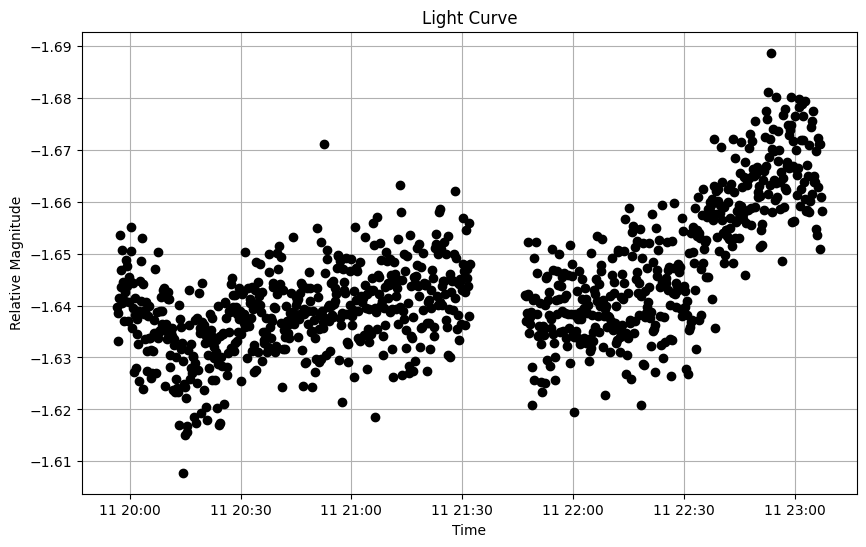

In [13]:
# 光度曲線のプロット
fig = plt.figure(figsize=(10, 6))
# plt.errorbar(times, rel_mags, yerr=errors, fmt='o', ecolor='gray', capsize=3)
plt.plot(times, rel_mags, 'o', color='black')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Relative Magnitude')
plt.title('Light Curve')
plt.grid(True)
plt.show()
fig.savefig('light_curve_toi1516.png')

### 光度曲線 (移動平均付き) のplot

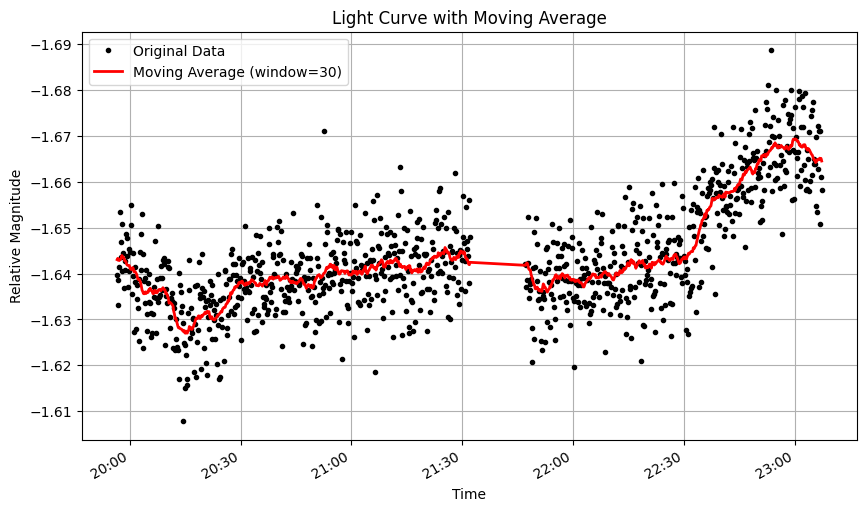

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

times_jst_naive = [dt.replace(tzinfo=None) if dt is not None and not isinstance(dt, float) else dt for dt in times]

# データをDataFrameに変換
df = pd.DataFrame({
    'Time': times_jst_naive,
    'Relative_Magnitude': rel_mags
})

# 'Time'をDatetimeIndexに設定
df.set_index('Time', inplace=True)

# 移動平均を計算
window_size = 30
df['Moving_Average'] = df['Relative_Magnitude'].rolling(window=window_size, center=True, min_periods=1).mean()

# 光度曲線のプロット
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.index, df['Relative_Magnitude'], 'o', color='black', markersize=3, label='Original Data')
ax.plot(df.index, df['Moving_Average'], '-', color='red', linewidth=2, label=f'Moving Average (window={window_size})')
ax.invert_yaxis()

ax.set_xlabel('Time')
ax.set_ylabel('Relative Magnitude')
ax.set_title('Light Curve with Moving Average')
ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()
plt.show()

fig.savefig('light_curve_toi1516_with_moving_average.png')


# 参照星の機械等級の時間変化

In [15]:
# 各参照星のflux listの長さを確認
for i, fluxes in enumerate(comp_fluxes_list):
    print(f'Comparison Star {i+1}: {len(fluxes)} fluxes')

# timesの長さを確認
print(f'Times length: {len(times)}')


Comparison Star 1: 963 fluxes
Comparison Star 2: 963 fluxes
Comparison Star 3: 963 fluxes
Comparison Star 4: 963 fluxes
Times length: 963


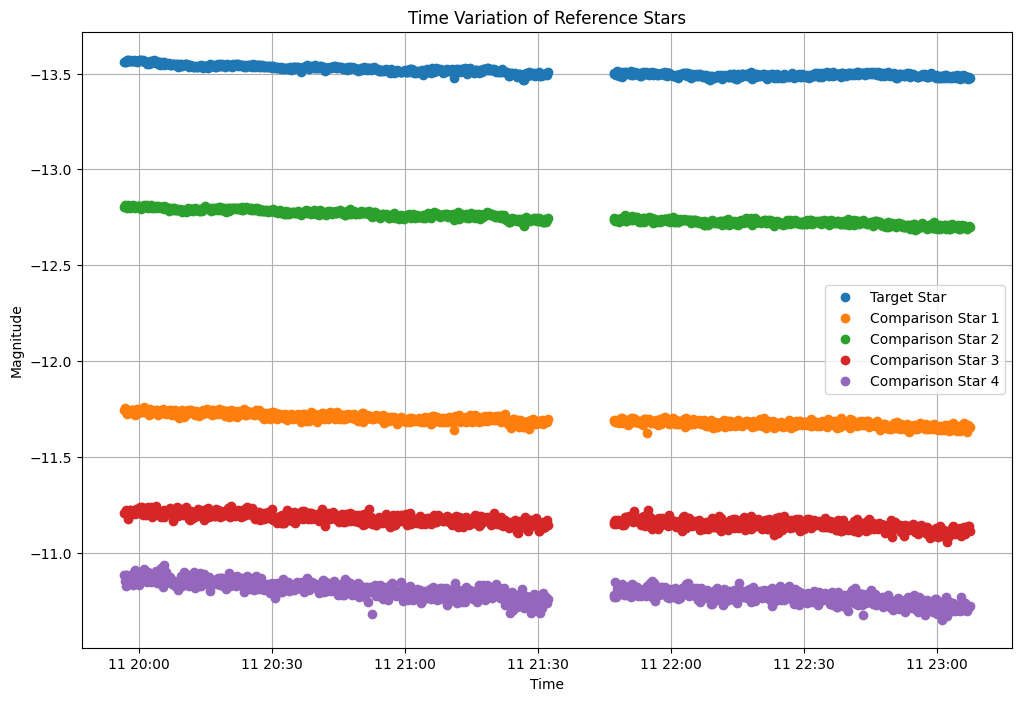

In [16]:
# 参照星の機械等級を計算
comp_mags_list = []
for fluxes in comp_fluxes_list:
    fluxes = np.array(fluxes)
    fluxes[fluxes <= 0] = 1e-10  # fluxがゼロまたは負の場合を避ける
    mags = -2.5 * np.log10(fluxes)
    comp_mags_list.append(mags)

# 参照星の機械等級の時間変化をプロット
fig = plt.figure(figsize=(12, 8))

plt.plot(times, target_mags, 'o', label='Target Star')
for i, mags in enumerate(comp_mags_list):
    plt.plot(times, mags, 'o', label=f'Comparison Star {i+1}')

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Time Variation of Reference Stars')
plt.legend()
plt.grid(True)
plt.show()
fig.savefig('light_curve_comp.png')


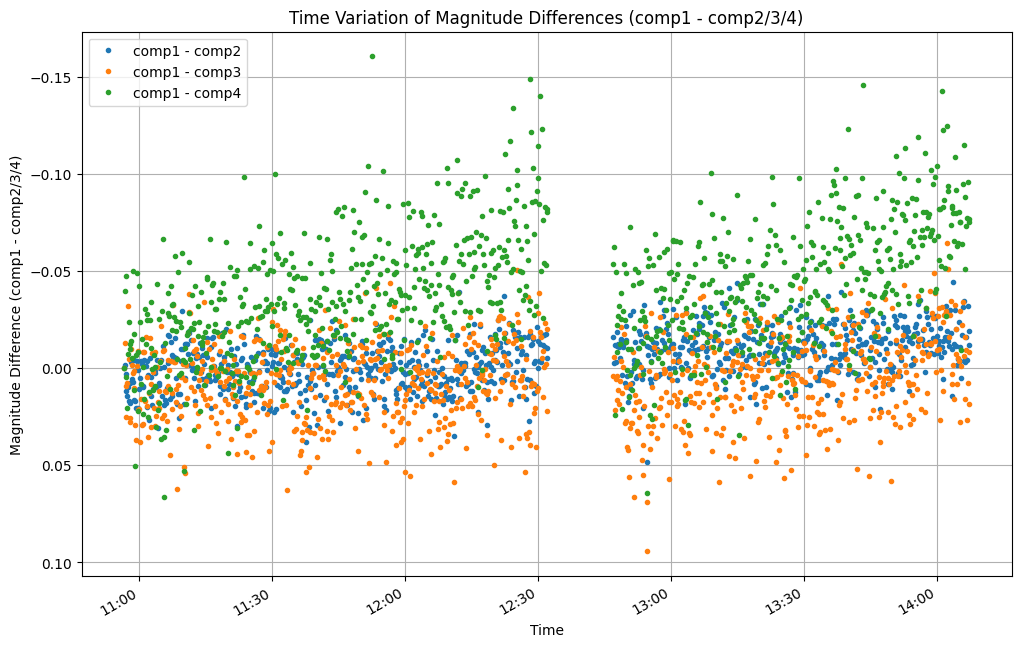

In [17]:
# 参照星の機械等級を計算
comp_mags_list = []
for fluxes in comp_fluxes_list:
    fluxes = np.array(fluxes)
    fluxes[fluxes <= 0] = 1e-10  # fluxがゼロまたは負の場合を避ける
    mags = -2.5 * np.log10(fluxes)
    comp_mags_list.append(mags)

comp1_mags = np.array(comp_mags_list[0])
comp2_mags = np.array(comp_mags_list[1])
comp3_mags = np.array(comp_mags_list[2])
comp4_mags = np.array(comp_mags_list[3])

diff_mag_comp1_comp2 = comp1_mags - comp2_mags
diff_mag_comp1_comp3 = comp1_mags - comp3_mags
diff_mag_comp1_comp4 = comp1_mags - comp4_mags

diff_mags_list = [diff_mag_comp1_comp2, diff_mag_comp1_comp3, diff_mag_comp1_comp4]
labels = ['comp1 - comp2', 'comp1 - comp3', 'comp1 - comp4']

adjusted_diff_mags_list = []

for diff_mag in diff_mags_list:
    # 最初の有効な値を見つける
    initial_value = np.nan
    for val in diff_mag:
        if not np.isnan(val):
            initial_value = val
            break
    if np.isnan(initial_value):
        # 全ての値がNaNの場合、そのまま
        adjusted_diff_mag = diff_mag
    else:
        # 最初の有効な値で引き算
        adjusted_diff_mag = diff_mag - initial_value
    adjusted_diff_mags_list.append(adjusted_diff_mag)


fig, ax = plt.subplots(figsize=(12, 8))

for adjusted_diff_mag, label in zip(adjusted_diff_mags_list, labels):
    ax.plot(times, adjusted_diff_mag, 'o', markersize=3, label=label)

ax.invert_yaxis()
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude Difference (comp1 - comp2/3/4)')
ax.set_title('Time Variation of Magnitude Differences (comp1 - comp2/3/4)')
ax.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()
plt.show()

# プロットの保存
fig.savefig('light_curve_diff_comp1_comp2_3_4_21.png')

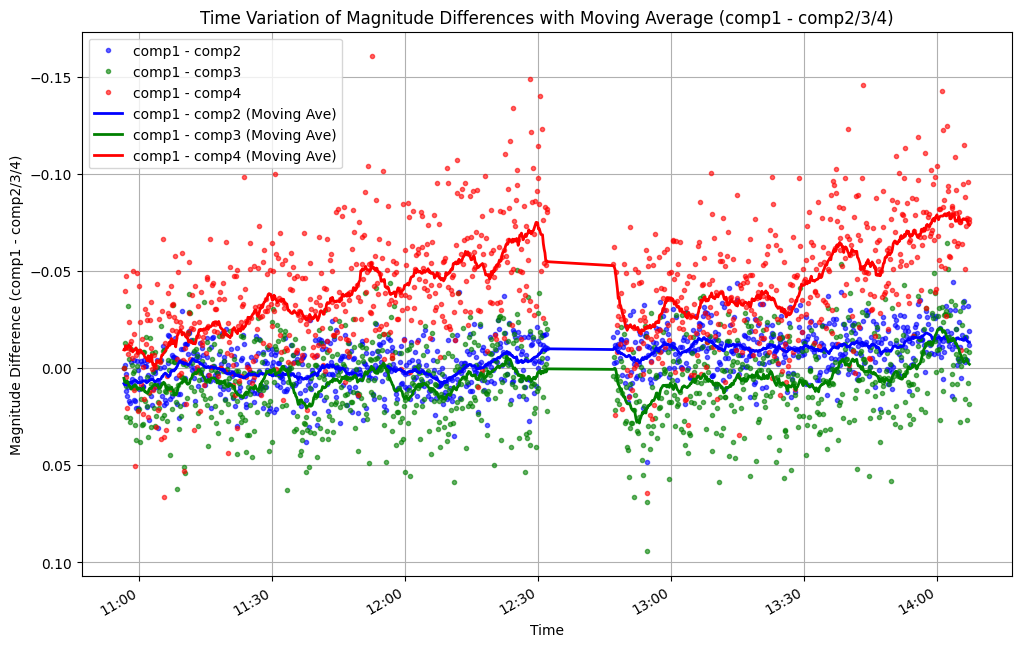

In [18]:
# 移動平均のウィンドウサイズ
window_size = 30

# 移動平均を計算し、新しいリストに追加
moving_avg_list = []

for adjusted_diff_mag in adjusted_diff_mags_list:
    # pandasのSeriesに変換
    series = pd.Series(adjusted_diff_mag)
    # 移動平均を計算
    moving_avg = series.rolling(window=window_size, center=True, min_periods=1).mean()
    # リストに追加
    moving_avg_list.append(moving_avg.values)

fig, ax = plt.subplots(figsize=(12, 8))


colors = ['blue', 'green', 'red']
for adjusted_diff_mag, label, color in zip(adjusted_diff_mags_list, labels, colors):
    ax.plot(times, adjusted_diff_mag, 'o', markersize=3, color=color, label=label, alpha=0.6)

for moving_avg, label, color in zip(moving_avg_list, labels, colors):
    ax.plot(times, moving_avg, '-', linewidth=2, color=color, label=f'{label} (Moving Ave)')

ax.invert_yaxis()
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude Difference (comp1 - comp2/3/4)')
ax.set_title('Time Variation of Magnitude Differences with Moving Average (comp1 - comp2/3/4)')
ax.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()
plt.show()
fig.savefig('light_curve_diff_comp_with_MA.png')

# comp4を消して相対測光やり直し

In [19]:
# 検索範囲（ピクセル単位）
search_radius = 15

# 結果を保存するリスト
times = []
rel_mags = []
errors = []
target_mags = []

# 位置データを保存するリスト
target_x = []
target_y = []

In [20]:
target_initial = (376.00, 295.00)
comp_initials = [
    (477.00, 324.00), 
    (474.00, 250.00), 
    (310.00, 190.00)
]

# 参照星の数を取得
num_comps = len(comp_initials)

# 各参照星のフラックスを保存するリストのリストを作成
comp_fluxes_list = [[] for _ in range(num_comps)]


comp_x_list = [[] for _ in range(len(comp_initials))]
comp_y_list = [[] for _ in range(len(comp_initials))]


In [21]:
# FITSファイルのリストを取得（日時順にソート）
fits_files = sorted(glob.glob('./data/10toi1516a010*.fit'))

# ターゲット星と比較星の現在の位置
target_position = target_initial
comp_positions = comp_initials.copy()

# タイムゾーンの設定
jst = ZoneInfo('Asia/Tokyo')

# 各画像での処理
for idx, file in enumerate(fits_files):
    print(f"Processing {file} ({idx+1}/{len(fits_files)})")
    try:
        with fits.open(file) as hdu:
            data = hdu[0].data
            header = hdu[0].header
    except Exception as e:
        print(f"Error opening {file}: {e}")
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        target_x.append(np.nan)
        target_y.append(np.nan)
        for comp_x, comp_y in zip(comp_x_list, comp_y_list):
            comp_x.append(np.nan)
            comp_y.append(np.nan)
        continue
    
    # 観測時刻を取得
    if 'DATE-OBS' in header:
        try:
            time_utc = Time(header['DATE-OBS']).to_datetime(timezone=timezone.utc)
            time_jst = time_utc.astimezone(jst)
        except Exception as e:
            print(f"Error converting time for {file}: {e}")
            times.append(np.nan)
            for flux_list in comp_fluxes_list:
                flux_list.append(np.nan)
            target_mags.append(np.nan)
            rel_mags.append(np.nan)
            errors.append(np.nan)
            target_x.append(np.nan)
            target_y.append(np.nan)
            for comp_x, comp_y in zip(comp_x_list, comp_y_list):
                comp_x.append(np.nan)
                comp_y.append(np.nan)
            continue
    else:
        print(f"DATE-OBS not found in {file}. Skipping.")
        times.append(np.nan)
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        target_x.append(np.nan)
        target_y.append(np.nan)
        for comp_x, comp_y in zip(comp_x_list, comp_y_list):
            comp_x.append(np.nan)
            comp_y.append(np.nan)
        continue
    times.append(time_jst)
    
    # ターゲット星の位置と明るい星の情報を取得
    target_position, brightest_star = find_star_position(data, target_position, search_radius=15)
    
    # ターゲット星の位置をリストに追加
    target_x.append(target_position[0])
    target_y.append(target_position[1])
    
    # FWHMの取得
    if brightest_star is not None and 'fwhm' in brightest_star:
        measured_fwhm = brightest_star['fwhm']
        aperture_radius = measured_fwhm * 1.5  # FWHMの1.5倍をアパーチャ半径とする
    else:
        aperture_radius = 6  # デフォルト値
    
    # 参照星の位置を検索し、リストに追加
    for i, comp_pos in enumerate(comp_positions):
        comp_positions[i], _ = find_star_position(data, comp_pos, search_radius=15)
        comp_x_list[i].append(comp_positions[i][0])
        comp_y_list[i].append(comp_positions[i][1])
    
    # 測光アパーチャーを定義（動的に設定した半径を使用）
    positions = [target_position] + comp_positions
    apertures = CircularAperture(positions, r=aperture_radius)
    
    # アパーチャで測光を実行
    phot_table_apertures = aperture_photometry(data, apertures)
    
    # 背景補正用アノラスを定義（各アパーチャに対して一つのアノラスを作成）
    annuli = CircularAnnulus(positions, r_in=aperture_radius + 1, r_out=aperture_radius + 4)
    
    # アノラスで測光を実行
    phot_table_annuli = aperture_photometry(data, annuli)
    
    # 各アパーチャに対応するアノラスのフラックスを取得
    bkg_fluxes = phot_table_annuli['aperture_sum'] / annuli.area * apertures.area
    
    # アパーチャ内の背景を差し引いたフラックスを計算
    target_flux = phot_table_apertures['aperture_sum'][0] - bkg_fluxes[0]
    comp_fluxes = phot_table_apertures['aperture_sum'][1:] - bkg_fluxes[1:]
    
    # フラックスが負になる場合は np.nan に設定
    target_flux = target_flux if target_flux > 0 else np.nan
    comp_fluxes = np.where(comp_fluxes > 0, comp_fluxes, np.nan)
    
    # 相対等級を計算
    if not np.isnan(target_flux) and not np.isnan(comp_fluxes).all():
        comp_flux = np.nanmean(comp_fluxes)
        if comp_flux > 0:
            rel_mag = -2.5 * np.log10(target_flux / comp_flux)
        else:
            rel_mag = np.nan
    else:
        rel_mag = np.nan
    rel_mags.append(rel_mag)

    # 機械等級を計算
    if not np.isnan(target_flux) and target_flux > 0:
        target_mag = -2.5 * np.log10(target_flux)
    else:
        target_mag = np.nan
    target_mags.append(target_mag)
    
    # 誤差の推定
    if not np.isnan(comp_flux):
        error = np.nanstd(comp_fluxes / comp_flux)
    else:
        error = np.nan
    errors.append(error)
    
    # 各参照星のフラックスをリストに追加
    for i, flux in enumerate(comp_fluxes):
        if i < len(comp_fluxes_list):
            comp_fluxes_list[i].append(flux)
            print(f'Comparison Star {i+1}: Flux = {flux}')
        else:
            print(f"Warning: More comparison stars detected than initial {len(comp_fluxes_list)}")


Processing ./data\10toi1516a010-0001_out.fit (1/523)
Comparison Star 1: Flux = 49775.89743542361
Comparison Star 2: Flux = 132317.43206719065
Comparison Star 3: Flux = 30440.915184630532
Processing ./data\10toi1516a010-0002_out.fit (2/523)
Comparison Star 1: Flux = 50270.6295218959
Comparison Star 2: Flux = 133427.19256856022
Comparison Star 3: Flux = 30383.62077849642
Processing ./data\10toi1516a010-0003_out.fit (3/523)
Comparison Star 1: Flux = 49682.639516861425
Comparison Star 2: Flux = 132466.852007114
Comparison Star 3: Flux = 30643.86147373721
Processing ./data\10toi1516a010-0004_out.fit (4/523)
Comparison Star 1: Flux = 49344.60840603481
Comparison Star 2: Flux = 132621.16098476498
Comparison Star 3: Flux = 30882.46008805046
Processing ./data\10toi1516a010-0005_out.fit (5/523)
Comparison Star 1: Flux = 48985.23597480339
Comparison Star 2: Flux = 131933.87463020178
Comparison Star 3: Flux = 30172.843237023626
Processing ./data\10toi1516a010-0006_out.fit (6/523)
Comparison Star 1

In [22]:
target_initial = (310.00, 167.00)
comp_initials = [
    (412.00, 195.00), 
    (409.00, 121.00), 
    (244.00, 61.00)
]

In [23]:
# FITSファイルのリストを取得（日時順にソート）
fits_files = sorted(glob.glob('./data/10toi1516a011*.fit'))

# ターゲット星と比較星の現在の位置
target_position = target_initial
comp_positions = comp_initials.copy()

# タイムゾーンの設定
jst = ZoneInfo('Asia/Tokyo')

# 各画像での処理
for idx, file in enumerate(fits_files):
    print(f"Processing {file} ({idx+1}/{len(fits_files)})")
    try:
        with fits.open(file) as hdu:
            data = hdu[0].data
            header = hdu[0].header
    except Exception as e:
        print(f"Error opening {file}: {e}")
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        target_x.append(np.nan)
        target_y.append(np.nan)
        for comp_x, comp_y in zip(comp_x_list, comp_y_list):
            comp_x.append(np.nan)
            comp_y.append(np.nan)
        continue
    
    # 観測時刻を取得
    if 'DATE-OBS' in header:
        try:
            time_utc = Time(header['DATE-OBS']).to_datetime(timezone=timezone.utc)
            time_jst = time_utc.astimezone(jst)
        except Exception as e:
            print(f"Error converting time for {file}: {e}")
            times.append(np.nan)
            for flux_list in comp_fluxes_list:
                flux_list.append(np.nan)
            target_mags.append(np.nan)
            rel_mags.append(np.nan)
            errors.append(np.nan)
            target_x.append(np.nan)
            target_y.append(np.nan)
            for comp_x, comp_y in zip(comp_x_list, comp_y_list):
                comp_x.append(np.nan)
                comp_y.append(np.nan)
            continue
    else:
        print(f"DATE-OBS not found in {file}. Skipping.")
        times.append(np.nan)
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        target_x.append(np.nan)
        target_y.append(np.nan)
        for comp_x, comp_y in zip(comp_x_list, comp_y_list):
            comp_x.append(np.nan)
            comp_y.append(np.nan)
        continue
    times.append(time_jst)
    
    # ターゲット星の位置と明るい星の情報を取得
    target_position, brightest_star = find_star_position(data, target_position, search_radius=15)
    
    # ターゲット星の位置をリストに追加
    target_x.append(target_position[0])
    target_y.append(target_position[1])
    
    # FWHMの取得
    if brightest_star is not None and 'fwhm' in brightest_star:
        measured_fwhm = brightest_star['fwhm']
        aperture_radius = measured_fwhm * 1.5  # FWHMの1.5倍をアパーチャ半径とする
    else:
        aperture_radius = 6  # デフォルト値
    
    # 参照星の位置を検索し、リストに追加
    for i, comp_pos in enumerate(comp_positions):
        comp_positions[i], _ = find_star_position(data, comp_pos, search_radius=15)
        comp_x_list[i].append(comp_positions[i][0])
        comp_y_list[i].append(comp_positions[i][1])
    
    # 測光アパーチャーを定義（動的に設定した半径を使用）
    positions = [target_position] + comp_positions
    apertures = CircularAperture(positions, r=aperture_radius)
    
    # アパーチャで測光を実行
    phot_table_apertures = aperture_photometry(data, apertures)
    
    # 背景補正用アノラスを定義（各アパーチャに対して一つのアノラスを作成）
    annuli = CircularAnnulus(positions, r_in=aperture_radius + 1, r_out=aperture_radius + 4)
    
    # アノラスで測光を実行
    phot_table_annuli = aperture_photometry(data, annuli)
    
    # 各アパーチャに対応するアノラスのフラックスを取得
    bkg_fluxes = phot_table_annuli['aperture_sum'] / annuli.area * apertures.area
    
    # アパーチャ内の背景を差し引いたフラックスを計算
    target_flux = phot_table_apertures['aperture_sum'][0] - bkg_fluxes[0]
    comp_fluxes = phot_table_apertures['aperture_sum'][1:] - bkg_fluxes[1:]
    
    # フラックスが負になる場合は np.nan に設定
    target_flux = target_flux if target_flux > 0 else np.nan
    comp_fluxes = np.where(comp_fluxes > 0, comp_fluxes, np.nan)
    
    # 相対等級を計算
    if not np.isnan(target_flux) and not np.isnan(comp_fluxes).all():
        comp_flux = np.nanmean(comp_fluxes)
        if comp_flux > 0:
            rel_mag = -2.5 * np.log10(target_flux / comp_flux)
        else:
            rel_mag = np.nan
    else:
        rel_mag = np.nan
    rel_mags.append(rel_mag)

    # 機械等級を計算
    if not np.isnan(target_flux) and target_flux > 0:
        target_mag = -2.5 * np.log10(target_flux)
    else:
        target_mag = np.nan
    target_mags.append(target_mag)
    
    # 誤差の推定
    if not np.isnan(comp_flux):
        error = np.nanstd(comp_fluxes / comp_flux)
    else:
        error = np.nan
    errors.append(error)
    
    # 各参照星のフラックスをリストに追加
    for i, flux in enumerate(comp_fluxes):
        if i < len(comp_fluxes_list):
            comp_fluxes_list[i].append(flux)
            print(f'Comparison Star {i+1}: Flux = {flux}')
        else:
            print(f"Warning: More comparison stars detected than initial {len(comp_fluxes_list)}")


Processing ./data\10toi1516a011-0001_out.fit (1/440)
Comparison Star 1: Flux = 47445.5795324661
Comparison Star 2: Flux = 124288.65732157712
Comparison Star 3: Flux = 29127.729650353023
Processing ./data\10toi1516a011-0002_out.fit (2/440)
Comparison Star 1: Flux = 47386.639464535445
Comparison Star 2: Flux = 125681.64374947187
Comparison Star 3: Flux = 28828.765449936167
Processing ./data\10toi1516a011-0003_out.fit (3/440)
Comparison Star 1: Flux = 47130.519509216625
Comparison Star 2: Flux = 123919.94057566833
Comparison Star 3: Flux = 29401.602906663495
Processing ./data\10toi1516a011-0004_out.fit (4/440)
Comparison Star 1: Flux = 46978.82162986652
Comparison Star 2: Flux = 124538.376855978
Comparison Star 3: Flux = 28880.642657319913
Processing ./data\10toi1516a011-0005_out.fit (5/440)
Comparison Star 1: Flux = 47558.87349299935
Comparison Star 2: Flux = 124268.06745283375
Comparison Star 3: Flux = 29191.069380216228
Processing ./data\10toi1516a011-0006_out.fit (6/440)
Comparison St

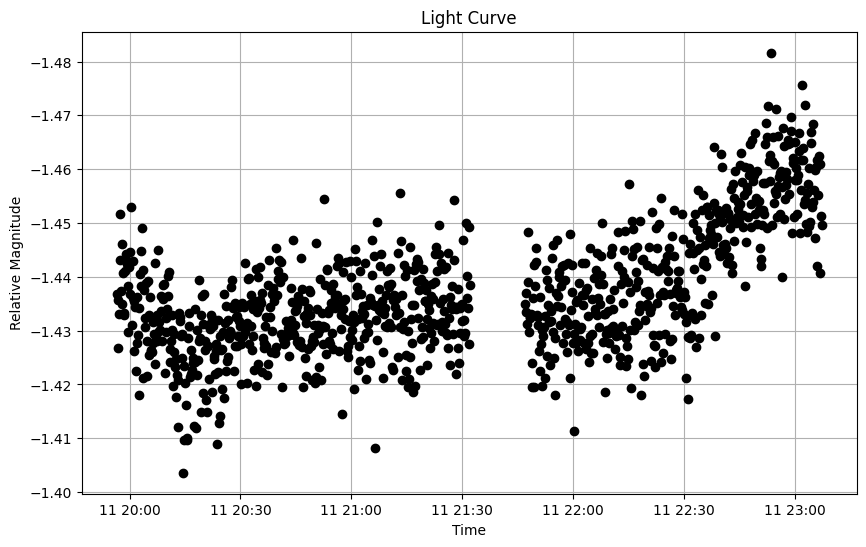

In [24]:
# 光度曲線のプロット
fig = plt.figure(figsize=(10, 6))
# plt.errorbar(times, rel_mags, yerr=errors, fmt='o', ecolor='gray', capsize=3)
plt.plot(times, rel_mags, 'o', color='black')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Relative Magnitude')
plt.title('Light Curve')
plt.grid(True)
plt.show()
fig.savefig('light_curve_toi1516_2.png')

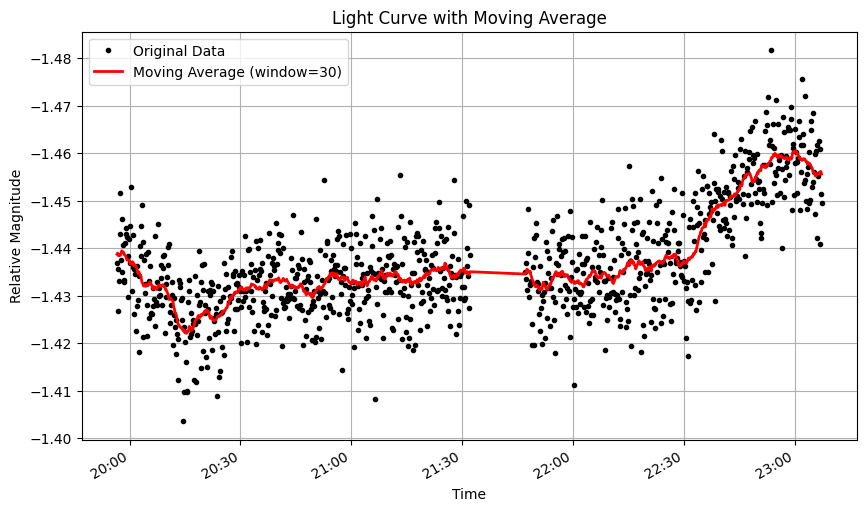

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

times_jst_naive = [dt.replace(tzinfo=None) if dt is not None and not isinstance(dt, float) else dt for dt in times]

# データをDataFrameに変換
df = pd.DataFrame({
    'Time': times_jst_naive,
    'Relative_Magnitude': rel_mags
})

# 'Time'をDatetimeIndexに設定
df.set_index('Time', inplace=True)

# 移動平均を計算
window_size = 30
df['Moving_Average'] = df['Relative_Magnitude'].rolling(window=window_size, center=True, min_periods=1).mean()

# 光度曲線のプロット
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.index, df['Relative_Magnitude'], 'o', color='black', markersize=3, label='Original Data')
ax.plot(df.index, df['Moving_Average'], '-', color='red', linewidth=2, label=f'Moving Average (window={window_size})')
ax.invert_yaxis()

ax.set_xlabel('Time')
ax.set_ylabel('Relative Magnitude')
ax.set_title('Light Curve with Moving Average')
ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()
plt.show()

fig.savefig('light_curve_toi1516_with_moving_average_2.png')


In [26]:
fits_files = sorted(glob.glob('./data/10toi1516a010*.fit'))
if not fits_files:
    raise FileNotFoundError("指定されたディレクトリにFITSファイルが見つかりません。")

with fits.open(fits_files[0]) as hdu:
    header = hdu[0].header
    image_width = header.get('NAXIS1')
    image_height = header.get('NAXIS2')

    if image_width is None or image_height is None:
        raise ValueError(f"FITSファイル {fits_files[0]} に画像サイズ情報が含まれていません。")

print(f"取得した画像サイズ: 幅={image_width} px, 高さ={image_height} px")


取得した画像サイズ: 幅=840 px, 高さ=736 px


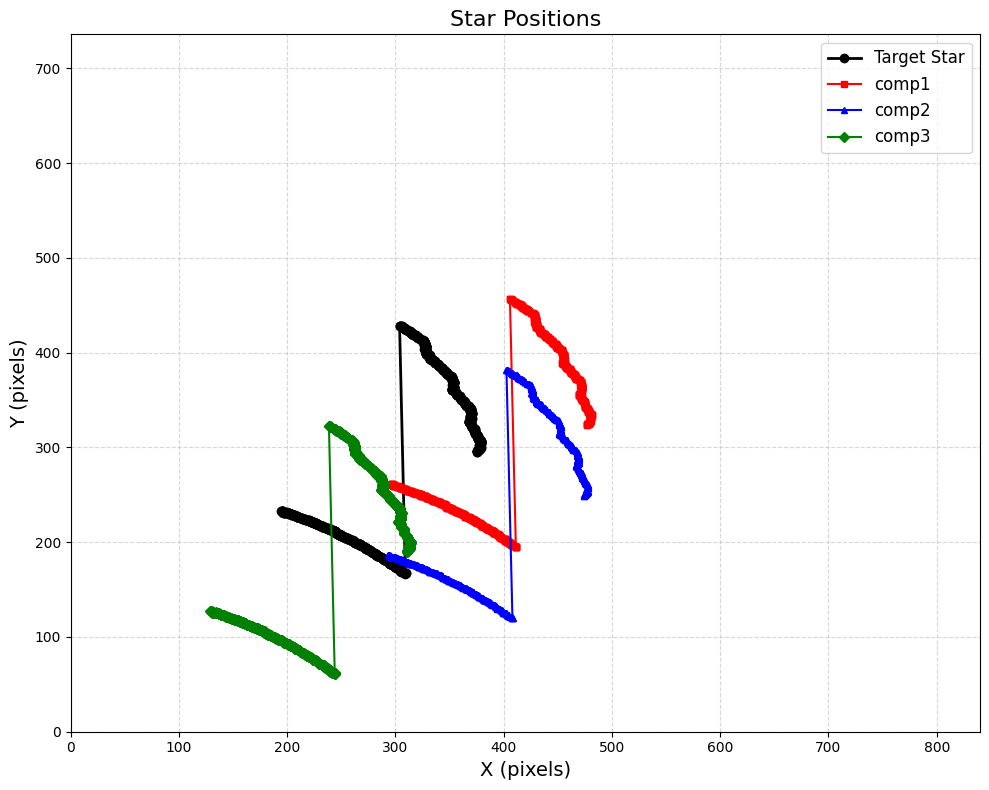

In [27]:
plt.figure(figsize=(10, 8))

plt.plot(target_x, target_y, 'o-', color='black', label='Target Star', markersize=6, linewidth=2)

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan']
markers = ['s', '^', 'D', 'v', 'P', 'X', '*'] 

for i in range(len(comp_x_list)):
    plt.plot(comp_x_list[i], comp_y_list[i],
             marker=markers[i % len(markers)],
             linestyle='-', color=colors[i % len(colors)],
             label=f'comp{i+1}', markersize=5, linewidth=1.5)

plt.xlabel('X (pixels)', fontsize=14)
plt.ylabel('Y (pixels)', fontsize=14)
plt.title('Star Positions', fontsize=16)

plt.legend(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)

# all_x = target_x + [x for sublist in comp_x_list for x in sublist]
# all_y = target_y + [y for sublist in comp_y_list for y in sublist]

# plt.xlim(min(all_x) - 10, max(all_x) + 10)
# plt.ylim(min(all_y) - 10, max(all_y) + 10)
plt.xlim(0, image_width)
plt.ylim(0, image_height)

plt.tight_layout()
plt.savefig('star_positions_over_time.png', dpi=300)
plt.show()


# エアマスの計算

In [28]:
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, SkyCoord
import astropy.units as u
from datetime import datetime, timedelta

# RADecを入れると高度と方位角を返す関数
def calculate_alt_az(ra, dec, observation_time_str):
    # 京都大学(観測地点)の緯度経度高度
    location = EarthLocation(lat=35.0309*u.deg, lon=135.7832*u.deg, height=115.1*u.m)

    # 観測時刻をAstropyのTimeオブジェクトに変換
    utcoffset = 9*u.hour
    observation_time = Time(observation_time_str) - utcoffset
    # print(observation_time)

    # RADecを天球座標に変換
    sky_coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')

    # 地平座標系（高度altと方位角az）に変換
    altaz_frame = AltAz(obstime=observation_time, location=location)
    altaz = sky_coord.transform_to(altaz_frame)
    # print(altaz)

    return altaz.alt.degree, altaz.az.degree  

# alt, az= calculate_alt_az(ra, dec, '2024-11-11 19:00:00')
# 19:45--23:15

In [29]:
ra_deg = 22.672294
dec_deg = 69.503739

# 観測期間の設定
start_time_str = '2024-11-11 19:45:00'
end_time_str = '2024-11-11 23:15:00'

# 観測間隔の設定
time_interval = timedelta(minutes=1)

# 観測開始時刻と終了時刻のdatetimeオブジェクトへの変換
start_time = datetime.strptime(start_time_str, '%Y-%m-%d %H:%M:%S')
end_time = datetime.strptime(end_time_str, '%Y-%m-%d %H:%M:%S')

observation_times = []
current_time = start_time
while current_time <= end_time:
    observation_times.append(current_time.strftime('%Y-%m-%d %H:%M:%S'))
    current_time += time_interval

print(f"生成された観測時刻の数: {len(observation_times)}")

altitudes = []
azimuths = []

for obs_time in observation_times:
    alt, az = calculate_alt_az(ra_deg, dec_deg, obs_time)
    altitudes.append(alt)
    azimuths.append(az)

print("計算完了")


生成された観測時刻の数: 211
計算完了


In [30]:
print("Observation start:", observation_times[0])
print("Observation end:", observation_times[-1])


Observation start: 2024-11-11 19:45:00
Observation end: 2024-11-11 23:15:00


In [31]:
print(observation_times)

['2024-11-11 19:45:00', '2024-11-11 19:46:00', '2024-11-11 19:47:00', '2024-11-11 19:48:00', '2024-11-11 19:49:00', '2024-11-11 19:50:00', '2024-11-11 19:51:00', '2024-11-11 19:52:00', '2024-11-11 19:53:00', '2024-11-11 19:54:00', '2024-11-11 19:55:00', '2024-11-11 19:56:00', '2024-11-11 19:57:00', '2024-11-11 19:58:00', '2024-11-11 19:59:00', '2024-11-11 20:00:00', '2024-11-11 20:01:00', '2024-11-11 20:02:00', '2024-11-11 20:03:00', '2024-11-11 20:04:00', '2024-11-11 20:05:00', '2024-11-11 20:06:00', '2024-11-11 20:07:00', '2024-11-11 20:08:00', '2024-11-11 20:09:00', '2024-11-11 20:10:00', '2024-11-11 20:11:00', '2024-11-11 20:12:00', '2024-11-11 20:13:00', '2024-11-11 20:14:00', '2024-11-11 20:15:00', '2024-11-11 20:16:00', '2024-11-11 20:17:00', '2024-11-11 20:18:00', '2024-11-11 20:19:00', '2024-11-11 20:20:00', '2024-11-11 20:21:00', '2024-11-11 20:22:00', '2024-11-11 20:23:00', '2024-11-11 20:24:00', '2024-11-11 20:25:00', '2024-11-11 20:26:00', '2024-11-11 20:27:00', '2024-11-1

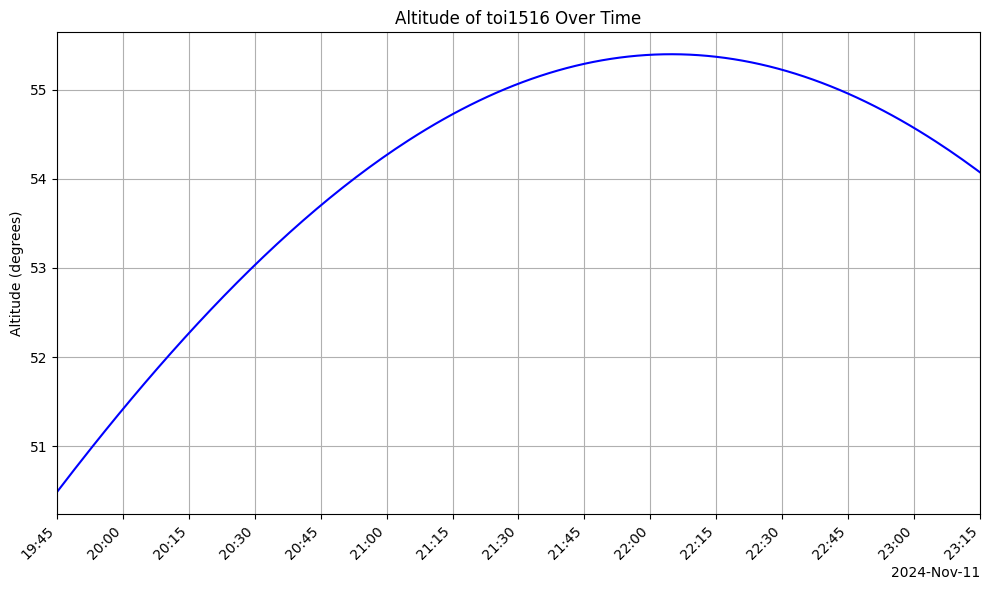

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# observation_times が文字列の場合、datetimeオブジェクトに変換
observation_datetimes = [datetime.strptime(t, "%Y-%m-%d %H:%M:%S") for t in observation_times]

fig, ax = plt.subplots(figsize=(10, 6))

# 変換した datetime オブジェクトを使ってプロット
ax.plot(observation_datetimes, altitudes, color='blue', label='Altitude')

ax.set_ylabel('Altitude (degrees)')
ax.set_title('Altitude of toi1516 Over Time')
ax.grid(True)

# x軸に対して日付として扱うことを明示的に宣言
ax.xaxis_date()

# データ範囲に合わせて軸範囲を設定
ax.set_xlim(observation_datetimes[0], observation_datetimes[-1])

# 15分おきの目盛り設定
locator = mdates.MinuteLocator(interval=15)
ax.xaxis.set_major_locator(locator)

# ConciseDateFormatterを適用
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('toi1516_alz_over_time.png', dpi=300)
plt.show()


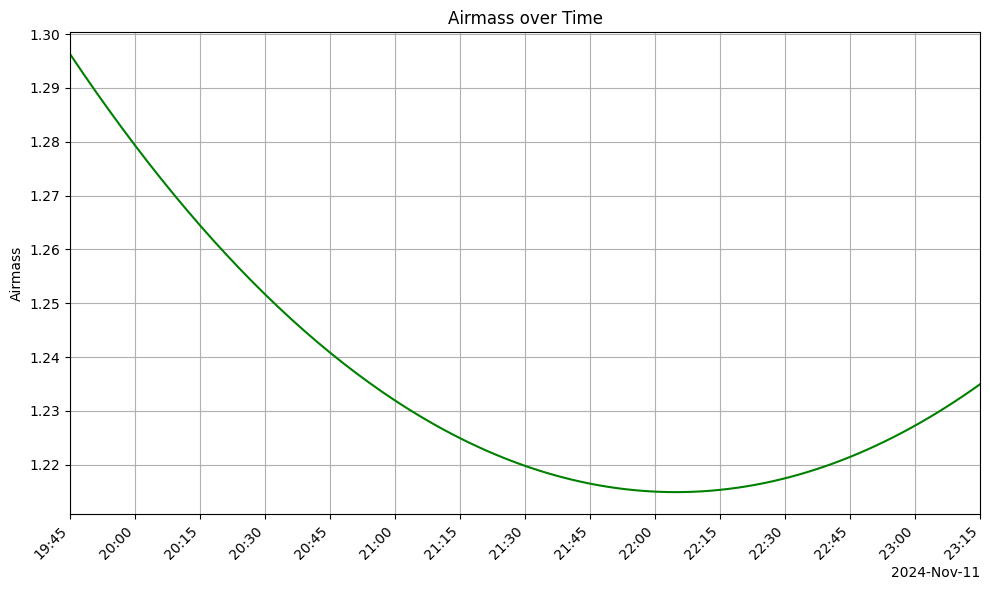

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

# もし observation_times が文字列の場合は datetime オブジェクトに変換
observation_datetimes = [datetime.strptime(t, "%Y-%m-%d %H:%M:%S") for t in observation_times]

# エアマスの計算（altitudesは度単位で与えられていると仮定）
airmass = 1.0 / np.sin(np.radians(altitudes))  # sin()はラジアン単位で受け付けるためradiansに変換

fig, ax = plt.subplots(figsize=(10, 6))

# エアマスをプロット
ax.plot(observation_datetimes, airmass, color='green', label='Airmass')

ax.set_ylabel('Airmass')
ax.set_title('Airmass over Time')
ax.grid(True)

# x軸を日付として扱い、15分おきに目盛りを表示
ax.xaxis_date()  
locator = mdates.MinuteLocator(interval=15)
ax.xaxis.set_major_locator(locator)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)

# 軸範囲をデータの範囲に合わせる
ax.set_xlim(observation_datetimes[0], observation_datetimes[-1])

# 日付ラベルの向き調整
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('airmass_over_time.png', dpi=300)
plt.show()


# Fluxで相対測光

In [34]:
# 検索範囲（ピクセル単位）
search_radius = 15

# 結果を保存するリスト
times = []
rel_mags = []
rel_fluxes = []
errors = []
target_mags = []

# 位置データを保存するリスト
target_x = []
target_y = []

In [35]:
target_initial = (376.00, 295.00)
comp_initials = [
    (477.00, 324.00), 
    (474.00, 250.00), 
    (310.00, 190.00)
]

# 参照星の数を取得
num_comps = len(comp_initials)

# 各参照星のフラックスを保存するリストのリストを作成
comp_fluxes_list = [[] for _ in range(num_comps)]


comp_x_list = [[] for _ in range(len(comp_initials))]
comp_y_list = [[] for _ in range(len(comp_initials))]


In [36]:
# FITSファイルのリストを取得（日時順にソート）
fits_files = sorted(glob.glob('./data/10toi1516a010*.fit'))

# ターゲット星と参照星の現在の位置
target_position = target_initial
comp_positions = comp_initials.copy()

for idx, file in enumerate(fits_files):
    print(f"Processing {file} ({idx+1}/{len(fits_files)})")
    try:
        with fits.open(file) as hdu:
            data = hdu[0].data
            header = hdu[0].header
    except Exception as e:
        print(f"Error opening {file}: {e}")
        # 失敗時はNaNを挿入
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        continue
    
    # 観測時刻を取得
    if 'DATE-OBS' in header:
        time_utc = Time(header['DATE-OBS']).to_datetime(timezone=timezone.utc)
        time_jst = time_utc.astimezone(ZoneInfo('Asia/Tokyo'))
    else:
        print(f"DATE-OBS not found in {file}. Skipping.")
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        continue
    times.append(time_jst)
    
    # ターゲット星の位置と最も明るい星を検索
    target_position, brightest_star = find_star_position(data, target_position, search_radius=search_radius)
    
    # FWHM取得
    if brightest_star is not None and 'fwhm' in brightest_star:
        measured_fwhm = brightest_star['fwhm']
        aperture_radius = measured_fwhm * 1.5
    else:
        aperture_radius = 6  # デフォルト値
    
    # 参照星の位置更新
    for i, comp_pos in enumerate(comp_positions):
        comp_positions[i], _ = find_star_position(data, comp_pos, search_radius=search_radius)
    
    # 測光用アパーチャー定義
    positions = [target_position] + comp_positions
    apertures = CircularAperture(positions, r=aperture_radius)
    
    # アパーチャ測光
    phot_table_apertures = aperture_photometry(data, apertures)
    
    # バックグラウンド用アノラス定義
    annuli = CircularAnnulus(positions, r_in=aperture_radius + 1, r_out=aperture_radius + 4)
    phot_table_annuli = aperture_photometry(data, annuli)
    
    # 背景フラックス
    bkg_fluxes = phot_table_annuli['aperture_sum'] / annuli.area * apertures.area
    
    # 背景差し引きフラックス計算
    target_flux = phot_table_apertures['aperture_sum'][0] - bkg_fluxes[0]
    comp_fluxes = phot_table_apertures['aperture_sum'][1:] - bkg_fluxes[1:]
    
    # フラックスが負の値ならNaN化
    target_flux = target_flux if target_flux > 0 else np.nan
    comp_fluxes = np.where(comp_fluxes > 0, comp_fluxes, np.nan)
    
    # 参照星の平均フラックス計算
    comp_flux = np.nanmean(comp_fluxes)
    
    # 相対等級計算
    if not np.isnan(target_flux) and not np.isnan(comp_flux) and comp_flux > 0:
        rel_mag = -2.5 * np.log10(target_flux / comp_flux)
    else:
        rel_mag = np.nan
    
    rel_mags.append(rel_mag)

    # 機械等級
    if not np.isnan(target_flux) and target_flux > 0:
        target_mag = -2.5 * np.log10(target_flux)
    else:
        target_mag = np.nan
    target_mags.append(target_mag)
    
    # 誤差の推定
    if not np.isnan(comp_flux):
        error = np.nanstd(comp_fluxes / comp_flux)
    else:
        error = np.nan
    errors.append(error)
    
    # 各参照星フラックスをリストに追加
    for i, flux in enumerate(comp_fluxes):
        comp_fluxes_list[i].append(flux)
        print(f'Comparison Star {i+1}: Flux = {flux}')


Processing ./data\10toi1516a010-0001_out.fit (1/523)
Comparison Star 1: Flux = 49775.89743542361
Comparison Star 2: Flux = 132317.43206719065
Comparison Star 3: Flux = 30440.915184630532
Processing ./data\10toi1516a010-0002_out.fit (2/523)
Comparison Star 1: Flux = 50270.6295218959
Comparison Star 2: Flux = 133427.19256856022
Comparison Star 3: Flux = 30383.62077849642
Processing ./data\10toi1516a010-0003_out.fit (3/523)
Comparison Star 1: Flux = 49682.639516861425
Comparison Star 2: Flux = 132466.852007114
Comparison Star 3: Flux = 30643.86147373721
Processing ./data\10toi1516a010-0004_out.fit (4/523)
Comparison Star 1: Flux = 49344.60840603481
Comparison Star 2: Flux = 132621.16098476498
Comparison Star 3: Flux = 30882.46008805046
Processing ./data\10toi1516a010-0005_out.fit (5/523)
Comparison Star 1: Flux = 48985.23597480339
Comparison Star 2: Flux = 131933.87463020178
Comparison Star 3: Flux = 30172.843237023626
Processing ./data\10toi1516a010-0006_out.fit (6/523)
Comparison Star 1

In [37]:
target_initial = (310.00, 167.00)
comp_initials = [
    (412.00, 195.00), 
    (409.00, 121.00), 
    (244.00, 61.00)
]

In [38]:
# FITSファイルのリストを取得（日時順にソート）
fits_files = sorted(glob.glob('./data/10toi1516a011*.fit'))

# ターゲット星と参照星の現在の位置
target_position = target_initial
comp_positions = comp_initials.copy()

for idx, file in enumerate(fits_files):
    print(f"Processing {file} ({idx+1}/{len(fits_files)})")
    try:
        with fits.open(file) as hdu:
            data = hdu[0].data
            header = hdu[0].header
    except Exception as e:
        print(f"Error opening {file}: {e}")
        # 失敗時はNaNを挿入
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        continue
    
    # 観測時刻を取得
    if 'DATE-OBS' in header:
        time_utc = Time(header['DATE-OBS']).to_datetime(timezone=timezone.utc)
        time_jst = time_utc.astimezone(ZoneInfo('Asia/Tokyo'))
    else:
        print(f"DATE-OBS not found in {file}. Skipping.")
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        continue
    times.append(time_jst)
    
    # ターゲット星の位置と最も明るい星を検索
    target_position, brightest_star = find_star_position(data, target_position, search_radius=search_radius)
    
    # FWHM取得
    if brightest_star is not None and 'fwhm' in brightest_star:
        measured_fwhm = brightest_star['fwhm']
        aperture_radius = measured_fwhm * 1.5
    else:
        aperture_radius = 6  # デフォルト値
    
    # 参照星の位置更新
    for i, comp_pos in enumerate(comp_positions):
        comp_positions[i], _ = find_star_position(data, comp_pos, search_radius=search_radius)
    
    # 測光用アパーチャー定義
    positions = [target_position] + comp_positions
    apertures = CircularAperture(positions, r=aperture_radius)
    
    # アパーチャ測光
    phot_table_apertures = aperture_photometry(data, apertures)
    
    # バックグラウンド用アノラス定義
    annuli = CircularAnnulus(positions, r_in=aperture_radius + 1, r_out=aperture_radius + 4)
    phot_table_annuli = aperture_photometry(data, annuli)
    
    # 背景フラックス
    bkg_fluxes = phot_table_annuli['aperture_sum'] / annuli.area * apertures.area
    
    # 背景差し引きフラックス計算
    target_flux = phot_table_apertures['aperture_sum'][0] - bkg_fluxes[0]
    comp_fluxes = phot_table_apertures['aperture_sum'][1:] - bkg_fluxes[1:]
    
    # フラックスが負の値ならNaN化
    target_flux = target_flux if target_flux > 0 else np.nan
    comp_fluxes = np.where(comp_fluxes > 0, comp_fluxes, np.nan)
    
    # 参照星の平均フラックス計算
    comp_flux = np.nanmean(comp_fluxes)
    
    # 相対等級計算
    if not np.isnan(target_flux) and not np.isnan(comp_flux) and comp_flux > 0:
        rel_mag = -2.5 * np.log10(target_flux / comp_flux)
    else:
        rel_mag = np.nan
    
    rel_mags.append(rel_mag)

    # 機械等級
    if not np.isnan(target_flux) and target_flux > 0:
        target_mag = -2.5 * np.log10(target_flux)
    else:
        target_mag = np.nan
    target_mags.append(target_mag)
    
    # 誤差の推定
    if not np.isnan(comp_flux):
        error = np.nanstd(comp_fluxes / comp_flux)
    else:
        error = np.nan
    errors.append(error)
    
    # 各参照星フラックスをリストに追加
    for i, flux in enumerate(comp_fluxes):
        comp_fluxes_list[i].append(flux)
        print(f'Comparison Star {i+1}: Flux = {flux}')


Processing ./data\10toi1516a011-0001_out.fit (1/440)
Comparison Star 1: Flux = 47445.5795324661
Comparison Star 2: Flux = 124288.65732157712
Comparison Star 3: Flux = 29127.729650353023
Processing ./data\10toi1516a011-0002_out.fit (2/440)
Comparison Star 1: Flux = 47386.639464535445
Comparison Star 2: Flux = 125681.64374947187
Comparison Star 3: Flux = 28828.765449936167
Processing ./data\10toi1516a011-0003_out.fit (3/440)
Comparison Star 1: Flux = 47130.519509216625
Comparison Star 2: Flux = 123919.94057566833
Comparison Star 3: Flux = 29401.602906663495
Processing ./data\10toi1516a011-0004_out.fit (4/440)
Comparison Star 1: Flux = 46978.82162986652
Comparison Star 2: Flux = 124538.376855978
Comparison Star 3: Flux = 28880.642657319913
Processing ./data\10toi1516a011-0005_out.fit (5/440)
Comparison Star 1: Flux = 47558.87349299935
Comparison Star 2: Flux = 124268.06745283375
Comparison Star 3: Flux = 29191.069380216228
Processing ./data\10toi1516a011-0006_out.fit (6/440)
Comparison St

KeyboardInterrupt: 

In [ ]:
print(len(rel_mags))
print(len(times))

963
963


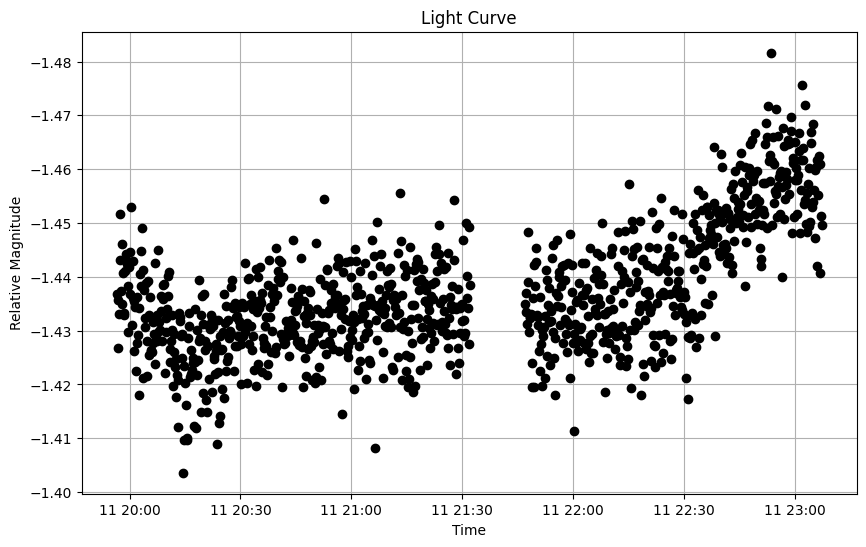

In [ ]:
# 光度曲線のプロット
fig = plt.figure(figsize=(10, 6))
# plt.errorbar(times, rel_mags, yerr=errors, fmt='o', ecolor='gray', capsize=3)
plt.plot(times, rel_mags, 'o', color='black')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Relative Magnitude')
plt.title('Light Curve')
plt.grid(True)
plt.show()
fig.savefig('light_curve_toi1516_3.png')

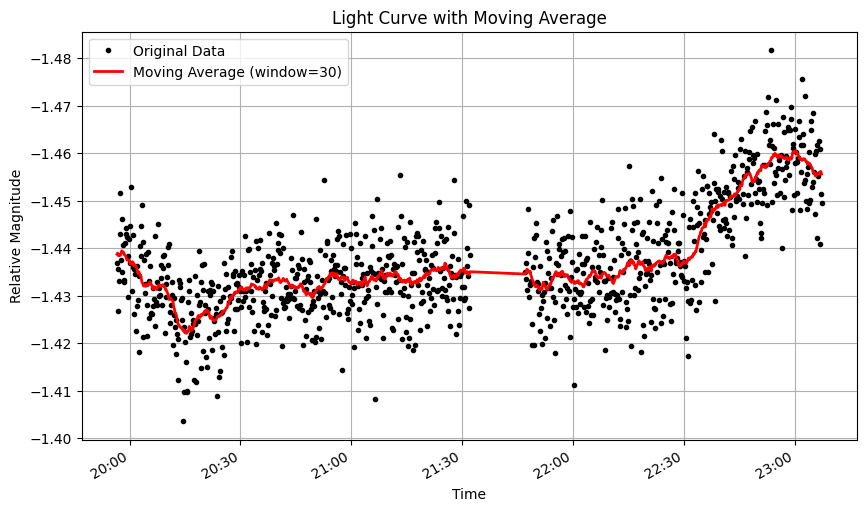

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

times_jst_naive = [dt.replace(tzinfo=None) if dt is not None and not isinstance(dt, float) else dt for dt in times]

# データをDataFrameに変換
df = pd.DataFrame({
    'Time': times_jst_naive,
    'Relative_Magnitude': rel_mags
})

# 'Time'をDatetimeIndexに設定
df.set_index('Time', inplace=True)

# 移動平均を計算
window_size = 30
df['Moving_Average'] = df['Relative_Magnitude'].rolling(window=window_size, center=True, min_periods=1).mean()

# 光度曲線のプロット
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.index, df['Relative_Magnitude'], 'o', color='black', markersize=3, label='Original Data')
ax.plot(df.index, df['Moving_Average'], '-', color='red', linewidth=2, label=f'Moving Average (window={window_size})')
ax.invert_yaxis()

ax.set_xlabel('Time')
ax.set_ylabel('Relative Magnitude')
ax.set_title('Light Curve with Moving Average')
ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()
plt.show()

fig.savefig('light_curve_toi1516_with_moving_average_3.png')


# HWHMの1.2倍で開口測光

In [39]:
# 検索範囲（ピクセル単位）
search_radius = 15

# 結果を保存するリスト
times = []
rel_mags = []
errors = []
target_mags = []

# 位置データを保存するリスト
target_x = []
target_y = []

In [40]:
target_initial = (376.00, 295.00)
comp_initials = [
    (477.00, 324.00), 
    (474.00, 250.00), 
    (310.00, 190.00)
]

# 参照星の数を取得
num_comps = len(comp_initials)

# 各参照星のフラックスを保存するリストのリストを作成
comp_fluxes_list = [[] for _ in range(num_comps)]


comp_x_list = [[] for _ in range(len(comp_initials))]
comp_y_list = [[] for _ in range(len(comp_initials))]


In [41]:
# FITSファイルのリストを取得（日時順にソート）
fits_files = sorted(glob.glob('./data/10toi1516a010*.fit'))

# ターゲット星と比較星の現在の位置
target_position = target_initial
comp_positions = comp_initials.copy()

# タイムゾーンの設定
jst = ZoneInfo('Asia/Tokyo')

# 各画像での処理
for idx, file in enumerate(fits_files):
    print(f"Processing {file} ({idx+1}/{len(fits_files)})")
    try:
        with fits.open(file) as hdu:
            data = hdu[0].data
            header = hdu[0].header
    except Exception as e:
        print(f"Error opening {file}: {e}")
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        target_x.append(np.nan)
        target_y.append(np.nan)
        for comp_x, comp_y in zip(comp_x_list, comp_y_list):
            comp_x.append(np.nan)
            comp_y.append(np.nan)
        continue
    
    # 観測時刻を取得
    if 'DATE-OBS' in header:
        try:
            time_utc = Time(header['DATE-OBS']).to_datetime(timezone=timezone.utc)
            time_jst = time_utc.astimezone(jst)
        except Exception as e:
            print(f"Error converting time for {file}: {e}")
            times.append(np.nan)
            for flux_list in comp_fluxes_list:
                flux_list.append(np.nan)
            target_mags.append(np.nan)
            rel_mags.append(np.nan)
            errors.append(np.nan)
            target_x.append(np.nan)
            target_y.append(np.nan)
            for comp_x, comp_y in zip(comp_x_list, comp_y_list):
                comp_x.append(np.nan)
                comp_y.append(np.nan)
            continue
    else:
        print(f"DATE-OBS not found in {file}. Skipping.")
        times.append(np.nan)
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        target_x.append(np.nan)
        target_y.append(np.nan)
        for comp_x, comp_y in zip(comp_x_list, comp_y_list):
            comp_x.append(np.nan)
            comp_y.append(np.nan)
        continue
    times.append(time_jst)
    
    # ターゲット星の位置と明るい星の情報を取得
    target_position, brightest_star = find_star_position(data, target_position, search_radius=15)
    
    # ターゲット星の位置をリストに追加
    target_x.append(target_position[0])
    target_y.append(target_position[1])
    
    # FWHMの取得
    if brightest_star is not None and 'fwhm' in brightest_star:
        measured_fwhm = brightest_star['fwhm']
        aperture_radius = measured_fwhm * 1.2  # FWHMの1.5倍をアパーチャ半径とする
    else:
        aperture_radius = 6  # デフォルト値
    
    # 参照星の位置を検索し、リストに追加
    for i, comp_pos in enumerate(comp_positions):
        comp_positions[i], _ = find_star_position(data, comp_pos, search_radius=15)
        comp_x_list[i].append(comp_positions[i][0])
        comp_y_list[i].append(comp_positions[i][1])
    
    # 測光アパーチャーを定義（動的に設定した半径を使用）
    positions = [target_position] + comp_positions
    apertures = CircularAperture(positions, r=aperture_radius)
    
    # アパーチャで測光を実行
    phot_table_apertures = aperture_photometry(data, apertures)
    
    # 背景補正用アノラスを定義（各アパーチャに対して一つのアノラスを作成）
    annuli = CircularAnnulus(positions, r_in=aperture_radius + 1, r_out=aperture_radius + 4)
    
    # アノラスで測光を実行
    phot_table_annuli = aperture_photometry(data, annuli)
    
    # 各アパーチャに対応するアノラスのフラックスを取得
    bkg_fluxes = phot_table_annuli['aperture_sum'] / annuli.area * apertures.area
    
    # アパーチャ内の背景を差し引いたフラックスを計算
    target_flux = phot_table_apertures['aperture_sum'][0] - bkg_fluxes[0]
    comp_fluxes = phot_table_apertures['aperture_sum'][1:] - bkg_fluxes[1:]
    
    # フラックスが負になる場合は np.nan に設定
    target_flux = target_flux if target_flux > 0 else np.nan
    comp_fluxes = np.where(comp_fluxes > 0, comp_fluxes, np.nan)
    
    # 相対等級を計算
    if not np.isnan(target_flux) and not np.isnan(comp_fluxes).all():
        comp_flux = np.nanmean(comp_fluxes)
        if comp_flux > 0:
            rel_mag = -2.5 * np.log10(target_flux / comp_flux)
        else:
            rel_mag = np.nan
    else:
        rel_mag = np.nan
    rel_mags.append(rel_mag)

    # 機械等級を計算
    if not np.isnan(target_flux) and target_flux > 0:
        target_mag = -2.5 * np.log10(target_flux)
    else:
        target_mag = np.nan
    target_mags.append(target_mag)
    
    # 誤差の推定
    if not np.isnan(comp_flux):
        error = np.nanstd(comp_fluxes / comp_flux)
    else:
        error = np.nan
    errors.append(error)
    
    # 各参照星のフラックスをリストに追加
    for i, flux in enumerate(comp_fluxes):
        if i < len(comp_fluxes_list):
            comp_fluxes_list[i].append(flux)
            print(f'Comparison Star {i+1}: Flux = {flux}')
        else:
            print(f"Warning: More comparison stars detected than initial {len(comp_fluxes_list)}")


Processing ./data\10toi1516a010-0001_out.fit (1/523)
Comparison Star 1: Flux = 49775.89743542361
Comparison Star 2: Flux = 132317.43206719065
Comparison Star 3: Flux = 30440.915184630532
Processing ./data\10toi1516a010-0002_out.fit (2/523)
Comparison Star 1: Flux = 50270.6295218959
Comparison Star 2: Flux = 133427.19256856022
Comparison Star 3: Flux = 30383.62077849642
Processing ./data\10toi1516a010-0003_out.fit (3/523)
Comparison Star 1: Flux = 49682.639516861425
Comparison Star 2: Flux = 132466.852007114
Comparison Star 3: Flux = 30643.86147373721
Processing ./data\10toi1516a010-0004_out.fit (4/523)
Comparison Star 1: Flux = 49344.60840603481
Comparison Star 2: Flux = 132621.16098476498
Comparison Star 3: Flux = 30882.46008805046
Processing ./data\10toi1516a010-0005_out.fit (5/523)
Comparison Star 1: Flux = 48985.23597480339
Comparison Star 2: Flux = 131933.87463020178
Comparison Star 3: Flux = 30172.843237023626
Processing ./data\10toi1516a010-0006_out.fit (6/523)
Comparison Star 1

In [42]:
target_initial = (310.00, 167.00)
comp_initials = [
    (412.00, 195.00), 
    (409.00, 121.00), 
    (244.00, 61.00)
]

In [44]:
# FITSファイルのリストを取得（日時順にソート）
fits_files = sorted(glob.glob('./data/10toi1516a011*.fit'))

# ターゲット星と比較星の現在の位置
target_position = target_initial
comp_positions = comp_initials.copy()

# タイムゾーンの設定
jst = ZoneInfo('Asia/Tokyo')

# 各画像での処理
for idx, file in enumerate(fits_files):
    print(f"Processing {file} ({idx+1}/{len(fits_files)})")
    try:
        with fits.open(file) as hdu:
            data = hdu[0].data
            header = hdu[0].header
    except Exception as e:
        print(f"Error opening {file}: {e}")
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        target_x.append(np.nan)
        target_y.append(np.nan)
        for comp_x, comp_y in zip(comp_x_list, comp_y_list):
            comp_x.append(np.nan)
            comp_y.append(np.nan)
        continue
    
    # 観測時刻を取得
    if 'DATE-OBS' in header:
        try:
            time_utc = Time(header['DATE-OBS']).to_datetime(timezone=timezone.utc)
            time_jst = time_utc.astimezone(jst)
        except Exception as e:
            print(f"Error converting time for {file}: {e}")
            times.append(np.nan)
            for flux_list in comp_fluxes_list:
                flux_list.append(np.nan)
            target_mags.append(np.nan)
            rel_mags.append(np.nan)
            errors.append(np.nan)
            target_x.append(np.nan)
            target_y.append(np.nan)
            for comp_x, comp_y in zip(comp_x_list, comp_y_list):
                comp_x.append(np.nan)
                comp_y.append(np.nan)
            continue
    else:
        print(f"DATE-OBS not found in {file}. Skipping.")
        times.append(np.nan)
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        target_x.append(np.nan)
        target_y.append(np.nan)
        for comp_x, comp_y in zip(comp_x_list, comp_y_list):
            comp_x.append(np.nan)
            comp_y.append(np.nan)
        continue
    times.append(time_jst)
    
    # ターゲット星の位置と明るい星の情報を取得
    target_position, brightest_star = find_star_position(data, target_position, search_radius=15)
    
    # ターゲット星の位置をリストに追加
    target_x.append(target_position[0])
    target_y.append(target_position[1])
    
    # FWHMの取得
    if brightest_star is not None and 'fwhm' in brightest_star:
        measured_fwhm = brightest_star['fwhm']
        aperture_radius = measured_fwhm * 1.2  # FWHMの1.5倍をアパーチャ半径とする
    else:
        aperture_radius = 6  # デフォルト値
    
    # 参照星の位置を検索し、リストに追加
    for i, comp_pos in enumerate(comp_positions):
        comp_positions[i], _ = find_star_position(data, comp_pos, search_radius=15)
        comp_x_list[i].append(comp_positions[i][0])
        comp_y_list[i].append(comp_positions[i][1])
    
    # 測光アパーチャーを定義（動的に設定した半径を使用）
    positions = [target_position] + comp_positions
    apertures = CircularAperture(positions, r=aperture_radius)
    
    # アパーチャで測光を実行
    phot_table_apertures = aperture_photometry(data, apertures)
    
    # 背景補正用アノラスを定義（各アパーチャに対して一つのアノラスを作成）
    annuli = CircularAnnulus(positions, r_in=aperture_radius + 1, r_out=aperture_radius + 4)
    
    # アノラスで測光を実行
    phot_table_annuli = aperture_photometry(data, annuli)
    
    # 各アパーチャに対応するアノラスのフラックスを取得
    bkg_fluxes = phot_table_annuli['aperture_sum'] / annuli.area * apertures.area
    
    # アパーチャ内の背景を差し引いたフラックスを計算
    target_flux = phot_table_apertures['aperture_sum'][0] - bkg_fluxes[0]
    comp_fluxes = phot_table_apertures['aperture_sum'][1:] - bkg_fluxes[1:]
    
    # フラックスが負になる場合は np.nan に設定
    target_flux = target_flux if target_flux > 0 else np.nan
    comp_fluxes = np.where(comp_fluxes > 0, comp_fluxes, np.nan)
    
    # 相対等級を計算
    if not np.isnan(target_flux) and not np.isnan(comp_fluxes).all():
        comp_flux = np.nanmean(comp_fluxes)
        if comp_flux > 0:
            rel_mag = -2.5 * np.log10(target_flux / comp_flux)
        else:
            rel_mag = np.nan
    else:
        rel_mag = np.nan
    rel_mags.append(rel_mag)

    # 機械等級を計算
    if not np.isnan(target_flux) and target_flux > 0:
        target_mag = -2.5 * np.log10(target_flux)
    else:
        target_mag = np.nan
    target_mags.append(target_mag)
    
    # 誤差の推定
    if not np.isnan(comp_flux):
        error = np.nanstd(comp_fluxes / comp_flux)
    else:
        error = np.nan
    errors.append(error)
    
    # 各参照星のフラックスをリストに追加
    for i, flux in enumerate(comp_fluxes):
        if i < len(comp_fluxes_list):
            comp_fluxes_list[i].append(flux)
            print(f'Comparison Star {i+1}: Flux = {flux}')
        else:
            print(f"Warning: More comparison stars detected than initial {len(comp_fluxes_list)}")


Processing ./data\10toi1516a011-0001_out.fit (1/440)
Comparison Star 1: Flux = 47445.5795324661
Comparison Star 2: Flux = 124288.65732157712
Comparison Star 3: Flux = 29127.729650353023
Processing ./data\10toi1516a011-0002_out.fit (2/440)
Comparison Star 1: Flux = 47386.639464535445
Comparison Star 2: Flux = 125681.64374947187
Comparison Star 3: Flux = 28828.765449936167
Processing ./data\10toi1516a011-0003_out.fit (3/440)
Comparison Star 1: Flux = 47130.519509216625
Comparison Star 2: Flux = 123919.94057566833
Comparison Star 3: Flux = 29401.602906663495
Processing ./data\10toi1516a011-0004_out.fit (4/440)
Comparison Star 1: Flux = 46978.82162986652
Comparison Star 2: Flux = 124538.376855978
Comparison Star 3: Flux = 28880.642657319913
Processing ./data\10toi1516a011-0005_out.fit (5/440)
Comparison Star 1: Flux = 47558.87349299935
Comparison Star 2: Flux = 124268.06745283375
Comparison Star 3: Flux = 29191.069380216228
Processing ./data\10toi1516a011-0006_out.fit (6/440)
Comparison St

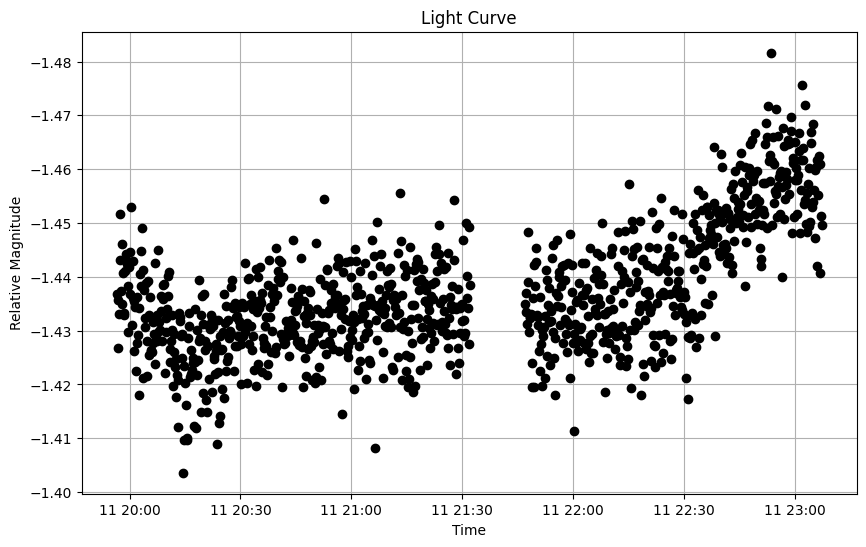

In [45]:
# 光度曲線のプロット
fig = plt.figure(figsize=(10, 6))
# plt.errorbar(times, rel_mags, yerr=errors, fmt='o', ecolor='gray', capsize=3)
plt.plot(times, rel_mags, 'o', color='black')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Relative Magnitude')
plt.title('Light Curve')
plt.grid(True)
plt.show()
fig.savefig('light_curve_toi1516_3.png')

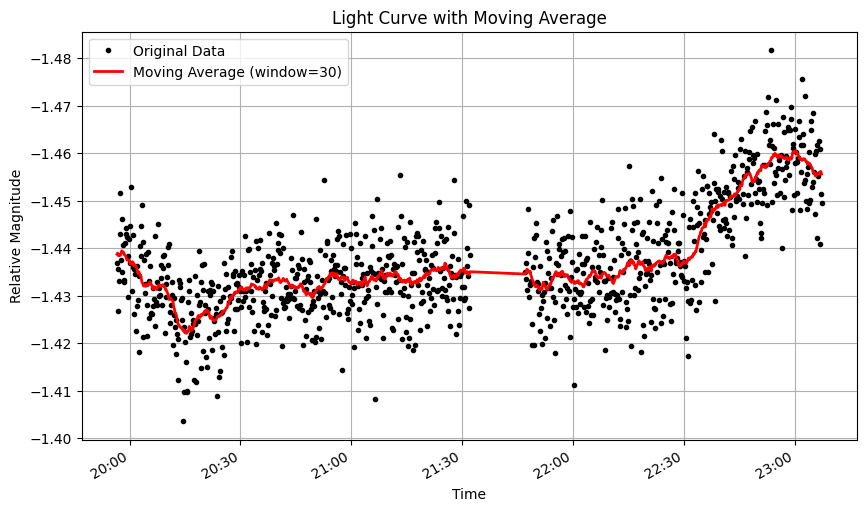

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

times_jst_naive = [dt.replace(tzinfo=None) if dt is not None and not isinstance(dt, float) else dt for dt in times]

# データをDataFrameに変換
df = pd.DataFrame({
    'Time': times_jst_naive,
    'Relative_Magnitude': rel_mags
})

# 'Time'をDatetimeIndexに設定
df.set_index('Time', inplace=True)

# 移動平均を計算
window_size = 30
df['Moving_Average'] = df['Relative_Magnitude'].rolling(window=window_size, center=True, min_periods=1).mean()

# 光度曲線のプロット
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.index, df['Relative_Magnitude'], 'o', color='black', markersize=3, label='Original Data')
ax.plot(df.index, df['Moving_Average'], '-', color='red', linewidth=2, label=f'Moving Average (window={window_size})')
ax.invert_yaxis()

ax.set_xlabel('Time')
ax.set_ylabel('Relative Magnitude')
ax.set_title('Light Curve with Moving Average')
ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()
plt.show()

fig.savefig('light_curve_toi1516_with_moving_average_3.png')


IndexError: list index out of range

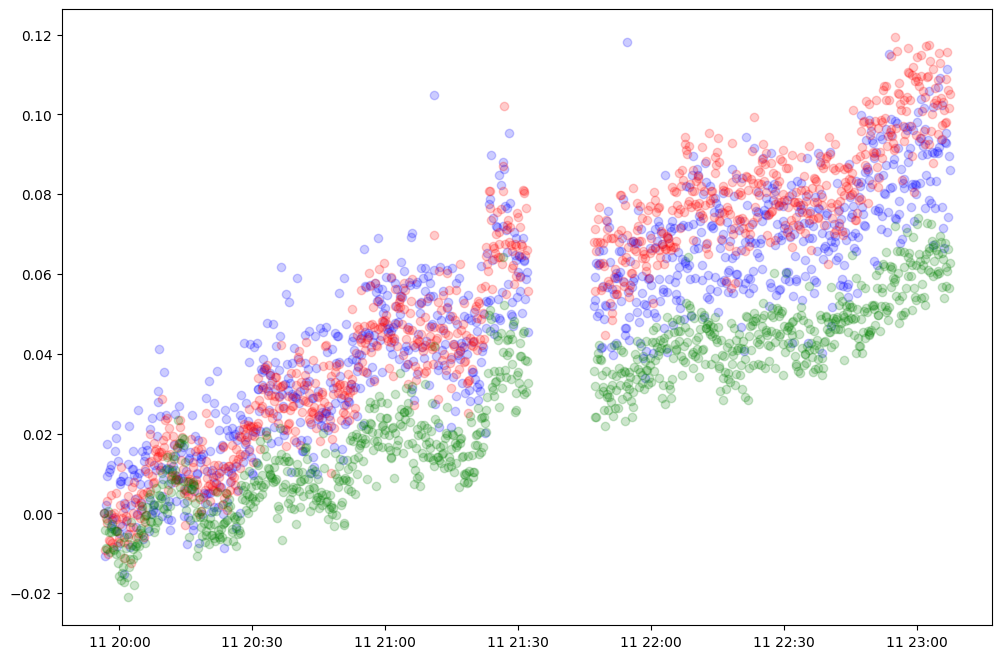

In [106]:
# 参照星の機械等級を計算
comp_mags_list = []
for fluxes in comp_fluxes_list:
    fluxes = np.array(fluxes)
    fluxes[fluxes <= 0] = 1e-10  # fluxがゼロまたは負の場合を避ける
    mags = -2.5 * np.log10(fluxes)
    comp_mags_list.append(mags)

window_size = 30
moving_avg_list = []
for mags in comp_mags_list:
    df = pd.DataFrame({
        'Time': times_jst_naive,
        'Magnitude': mags
    })
    df.set_index('Time', inplace=True)
    moving_avg = df['Magnitude'].rolling(window=window_size, center=True, min_periods=1).mean()
    moving_avg_list.append(moving_avg)
fig = plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green']

# plt.plot(times, target_mags-target_mags[0], 'o', label='Target Star', color='black', alpha=0.2)
# plt.plot(times, target_mags_ma-target_mags_ma[0], '-', label='Moving Average (Target Star)', color='black')
for i, mags in enumerate(comp_mags_list):
    plt.plot(times, mags-mags[0], 'o', label=f'Comparison Star {i+1}', alpha=0.2, color=colors[i])
for i, moving_avg in enumerate(moving_avg_list):
    plt.plot(times, moving_avg-moving_avg[0], '-', label=f'Moving Average {i+1}', color=colors[i])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Time Variation of Reference Stars')
plt.legend()
plt.grid(True)
plt.show()
fig.savefig('light_curve_comp.png')


In [105]:
target_mags_ma

[Time
 2024-11-11 19:56:35   -13.562577
 2024-11-11 19:56:46   -13.562577
 2024-11-11 19:56:57   -13.562577
 2024-11-11 19:57:08   -13.562577
 2024-11-11 19:57:19   -13.562577
                          ...    
 2024-11-11 23:06:35   -13.562577
 2024-11-11 23:06:46   -13.562577
 2024-11-11 23:06:57   -13.562577
 2024-11-11 23:07:08   -13.562577
 2024-11-11 23:07:19   -13.562577
 Name: Magnitude, Length: 963, dtype: float64,
 Time
 2024-11-11 19:56:35   -13.560461
 2024-11-11 19:56:46   -13.560461
 2024-11-11 19:56:57   -13.560461
 2024-11-11 19:57:08   -13.560461
 2024-11-11 19:57:19   -13.560461
                          ...    
 2024-11-11 23:06:35   -13.560461
 2024-11-11 23:06:46   -13.560461
 2024-11-11 23:06:57   -13.560461
 2024-11-11 23:07:08   -13.560461
 2024-11-11 23:07:19   -13.560461
 Name: Magnitude, Length: 963, dtype: float64,
 Time
 2024-11-11 19:56:35   -13.562799
 2024-11-11 19:56:46   -13.562799
 2024-11-11 19:56:57   -13.562799
 2024-11-11 19:57:08   -13.562799
 202

# 参照星を変更 12/16

In [90]:
# 検索範囲（ピクセル単位）
search_radius = 15

# 結果を保存するリスト
times = []
rel_mags = []
errors = []
target_mags = []

# 位置データを保存するリスト
target_x = []
target_y = []

In [91]:
target_initial = (376.00, 295.00)
comp_initials = [
    (477.00, 324.00), 
    (474.00, 250.00), 
    (602.00, 323.00), 
    (286.00, 321.00)
]

# 参照星の数を取得
num_comps = len(comp_initials)

# 各参照星のフラックスを保存するリストのリストを作成
comp_fluxes_list = [[] for _ in range(num_comps)]


comp_x_list = [[] for _ in range(len(comp_initials))]
comp_y_list = [[] for _ in range(len(comp_initials))]


In [92]:
# FITSファイルのリストを取得（日時順にソート）
fits_files = sorted(glob.glob('./data/10toi1516a010*.fit'))

# ターゲット星と比較星の現在の位置
target_position = target_initial
comp_positions = comp_initials.copy()

# タイムゾーンの設定
jst = ZoneInfo('Asia/Tokyo')

# 各画像での処理
for idx, file in enumerate(fits_files):
    print(f"Processing {file} ({idx+1}/{len(fits_files)})")
    try:
        with fits.open(file) as hdu:
            data = hdu[0].data
            header = hdu[0].header
    except Exception as e:
        print(f"Error opening {file}: {e}")
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        target_x.append(np.nan)
        target_y.append(np.nan)
        for comp_x, comp_y in zip(comp_x_list, comp_y_list):
            comp_x.append(np.nan)
            comp_y.append(np.nan)
        continue
    
    # 観測時刻を取得
    if 'DATE-OBS' in header:
        try:
            time_utc = Time(header['DATE-OBS']).to_datetime(timezone=timezone.utc)
            time_jst = time_utc.astimezone(jst)
        except Exception as e:
            print(f"Error converting time for {file}: {e}")
            times.append(np.nan)
            for flux_list in comp_fluxes_list:
                flux_list.append(np.nan)
            target_mags.append(np.nan)
            rel_mags.append(np.nan)
            errors.append(np.nan)
            target_x.append(np.nan)
            target_y.append(np.nan)
            for comp_x, comp_y in zip(comp_x_list, comp_y_list):
                comp_x.append(np.nan)
                comp_y.append(np.nan)
            continue
    else:
        print(f"DATE-OBS not found in {file}. Skipping.")
        times.append(np.nan)
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        target_x.append(np.nan)
        target_y.append(np.nan)
        for comp_x, comp_y in zip(comp_x_list, comp_y_list):
            comp_x.append(np.nan)
            comp_y.append(np.nan)
        continue
    times.append(time_jst)
    
    # ターゲット星の位置と明るい星の情報を取得
    target_position, brightest_star = find_star_position(data, target_position, search_radius=15)
    
    # ターゲット星の位置をリストに追加
    target_x.append(target_position[0])
    target_y.append(target_position[1])
    
    # FWHMの取得
    if brightest_star is not None and 'fwhm' in brightest_star:
        measured_fwhm = brightest_star['fwhm']
        aperture_radius = measured_fwhm * 1.2  # FWHMの1.5倍をアパーチャ半径とする
    else:
        aperture_radius = 6  # デフォルト値
    
    # 参照星の位置を検索し、リストに追加
    for i, comp_pos in enumerate(comp_positions):
        comp_positions[i], _ = find_star_position(data, comp_pos, search_radius=15)
        comp_x_list[i].append(comp_positions[i][0])
        comp_y_list[i].append(comp_positions[i][1])
    
    # 測光アパーチャーを定義（動的に設定した半径を使用）
    positions = [target_position] + comp_positions
    apertures = CircularAperture(positions, r=aperture_radius)
    
    # アパーチャで測光を実行
    phot_table_apertures = aperture_photometry(data, apertures)
    
    # 背景補正用アノラスを定義（各アパーチャに対して一つのアノラスを作成）
    annuli = CircularAnnulus(positions, r_in=aperture_radius + 1, r_out=aperture_radius + 4)
    
    # アノラスで測光を実行
    phot_table_annuli = aperture_photometry(data, annuli)
    
    # 各アパーチャに対応するアノラスのフラックスを取得
    bkg_fluxes = phot_table_annuli['aperture_sum'] / annuli.area * apertures.area
    
    # アパーチャ内の背景を差し引いたフラックスを計算
    target_flux = phot_table_apertures['aperture_sum'][0] - bkg_fluxes[0]
    comp_fluxes = phot_table_apertures['aperture_sum'][1:] - bkg_fluxes[1:]
    
    # フラックスが負になる場合は np.nan に設定
    target_flux = target_flux if target_flux > 0 else np.nan
    comp_fluxes = np.where(comp_fluxes > 0, comp_fluxes, np.nan)
    
    # 相対等級を計算
    if not np.isnan(target_flux) and not np.isnan(comp_fluxes).all():
        comp_flux = np.nanmean(comp_fluxes)
        if comp_flux > 0:
            rel_mag = -2.5 * np.log10(target_flux / comp_flux)
        else:
            rel_mag = np.nan
    else:
        rel_mag = np.nan
    rel_mags.append(rel_mag)

    # 機械等級を計算
    if not np.isnan(target_flux) and target_flux > 0:
        target_mag = -2.5 * np.log10(target_flux)
    else:
        target_mag = np.nan
    target_mags.append(target_mag)
    
    # 誤差の推定
    if not np.isnan(comp_flux):
        error = np.nanstd(comp_fluxes / comp_flux)
    else:
        error = np.nan
    errors.append(error)
    
    # 各参照星のフラックスをリストに追加
    for i, flux in enumerate(comp_fluxes):
        if i < len(comp_fluxes_list):
            comp_fluxes_list[i].append(flux)
            print(f'Comparison Star {i+1}: Flux = {flux}')
        else:
            print(f"Warning: More comparison stars detected than initial {len(comp_fluxes_list)}")


Processing ./data\10toi1516a010-0001_out.fit (1/523)
Comparison Star 1: Flux = 49775.89743542361
Comparison Star 2: Flux = 132317.43206719065
Comparison Star 3: Flux = 209659.62067537688
Comparison Star 4: Flux = 86314.29659256629
Processing ./data\10toi1516a010-0002_out.fit (2/523)
Comparison Star 1: Flux = 50270.6295218959
Comparison Star 2: Flux = 133427.19256856022
Comparison Star 3: Flux = 210469.55524539825
Comparison Star 4: Flux = 86470.67344279177
Processing ./data\10toi1516a010-0003_out.fit (3/523)
Comparison Star 1: Flux = 49682.639516861425
Comparison Star 2: Flux = 132466.852007114
Comparison Star 3: Flux = 211350.19158724035
Comparison Star 4: Flux = 87891.59539847702
Processing ./data\10toi1516a010-0004_out.fit (4/523)
Comparison Star 1: Flux = 49344.60840603481
Comparison Star 2: Flux = 132621.16098476498
Comparison Star 3: Flux = 209979.52032766468
Comparison Star 4: Flux = 86908.46689576644
Processing ./data\10toi1516a010-0005_out.fit (5/523)
Comparison Star 1: Flux =

In [93]:
target_initial = (310.00, 167.00)
comp_initials = [
    (412.00, 195.00), 
    (409.00, 121.00), 
    (536.00, 193.00), 
    (220.00, 193.00)
]

In [94]:
# FITSファイルのリストを取得（日時順にソート）
fits_files = sorted(glob.glob('./data/10toi1516a011*.fit'))

# ターゲット星と比較星の現在の位置
target_position = target_initial
comp_positions = comp_initials.copy()

# タイムゾーンの設定
jst = ZoneInfo('Asia/Tokyo')

# 各画像での処理
for idx, file in enumerate(fits_files):
    print(f"Processing {file} ({idx+1}/{len(fits_files)})")
    try:
        with fits.open(file) as hdu:
            data = hdu[0].data
            header = hdu[0].header
    except Exception as e:
        print(f"Error opening {file}: {e}")
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        target_x.append(np.nan)
        target_y.append(np.nan)
        for comp_x, comp_y in zip(comp_x_list, comp_y_list):
            comp_x.append(np.nan)
            comp_y.append(np.nan)
        continue
    
    # 観測時刻を取得
    if 'DATE-OBS' in header:
        try:
            time_utc = Time(header['DATE-OBS']).to_datetime(timezone=timezone.utc)
            time_jst = time_utc.astimezone(jst)
        except Exception as e:
            print(f"Error converting time for {file}: {e}")
            times.append(np.nan)
            for flux_list in comp_fluxes_list:
                flux_list.append(np.nan)
            target_mags.append(np.nan)
            rel_mags.append(np.nan)
            errors.append(np.nan)
            target_x.append(np.nan)
            target_y.append(np.nan)
            for comp_x, comp_y in zip(comp_x_list, comp_y_list):
                comp_x.append(np.nan)
                comp_y.append(np.nan)
            continue
    else:
        print(f"DATE-OBS not found in {file}. Skipping.")
        times.append(np.nan)
        for flux_list in comp_fluxes_list:
            flux_list.append(np.nan)
        target_mags.append(np.nan)
        rel_mags.append(np.nan)
        errors.append(np.nan)
        target_x.append(np.nan)
        target_y.append(np.nan)
        for comp_x, comp_y in zip(comp_x_list, comp_y_list):
            comp_x.append(np.nan)
            comp_y.append(np.nan)
        continue
    times.append(time_jst)
    
    # ターゲット星の位置と明るい星の情報を取得
    target_position, brightest_star = find_star_position(data, target_position, search_radius=15)
    
    # ターゲット星の位置をリストに追加
    target_x.append(target_position[0])
    target_y.append(target_position[1])
    
    # FWHMの取得
    if brightest_star is not None and 'fwhm' in brightest_star:
        measured_fwhm = brightest_star['fwhm']
        aperture_radius = measured_fwhm * 1.2  # FWHMの1.5倍をアパーチャ半径とする
    else:
        aperture_radius = 6  # デフォルト値
    
    # 参照星の位置を検索し、リストに追加
    for i, comp_pos in enumerate(comp_positions):
        comp_positions[i], _ = find_star_position(data, comp_pos, search_radius=15)
        comp_x_list[i].append(comp_positions[i][0])
        comp_y_list[i].append(comp_positions[i][1])
    
    # 測光アパーチャーを定義（動的に設定した半径を使用）
    positions = [target_position] + comp_positions
    apertures = CircularAperture(positions, r=aperture_radius)
    
    # アパーチャで測光を実行
    phot_table_apertures = aperture_photometry(data, apertures)
    
    # 背景補正用アノラスを定義（各アパーチャに対して一つのアノラスを作成）
    annuli = CircularAnnulus(positions, r_in=aperture_radius + 1, r_out=aperture_radius + 4)
    
    # アノラスで測光を実行
    phot_table_annuli = aperture_photometry(data, annuli)
    
    # 各アパーチャに対応するアノラスのフラックスを取得
    bkg_fluxes = phot_table_annuli['aperture_sum'] / annuli.area * apertures.area
    
    # アパーチャ内の背景を差し引いたフラックスを計算
    target_flux = phot_table_apertures['aperture_sum'][0] - bkg_fluxes[0]
    comp_fluxes = phot_table_apertures['aperture_sum'][1:] - bkg_fluxes[1:]
    
    # フラックスが負になる場合は np.nan に設定
    target_flux = target_flux if target_flux > 0 else np.nan
    comp_fluxes = np.where(comp_fluxes > 0, comp_fluxes, np.nan)
    
    # 相対等級を計算
    if not np.isnan(target_flux) and not np.isnan(comp_fluxes).all():
        comp_flux = np.nanmean(comp_fluxes)
        if comp_flux > 0:
            rel_mag = -2.5 * np.log10(target_flux / comp_flux)
        else:
            rel_mag = np.nan
    else:
        rel_mag = np.nan
    rel_mags.append(rel_mag)

    # 機械等級を計算
    if not np.isnan(target_flux) and target_flux > 0:
        target_mag = -2.5 * np.log10(target_flux)
    else:
        target_mag = np.nan
    target_mags.append(target_mag)
    
    # 誤差の推定
    if not np.isnan(comp_flux):
        error = np.nanstd(comp_fluxes / comp_flux)
    else:
        error = np.nan
    errors.append(error)
    
    # 各参照星のフラックスをリストに追加
    for i, flux in enumerate(comp_fluxes):
        if i < len(comp_fluxes_list):
            comp_fluxes_list[i].append(flux)
            print(f'Comparison Star {i+1}: Flux = {flux}')
        else:
            print(f"Warning: More comparison stars detected than initial {len(comp_fluxes_list)}")


Processing ./data\10toi1516a011-0001_out.fit (1/440)
Comparison Star 1: Flux = 47445.5795324661
Comparison Star 2: Flux = 124288.65732157712
Comparison Star 3: Flux = 202900.64094242174
Comparison Star 4: Flux = 83978.70915918851
Processing ./data\10toi1516a011-0002_out.fit (2/440)
Comparison Star 1: Flux = 47386.639464535445
Comparison Star 2: Flux = 125681.64374947187
Comparison Star 3: Flux = 205040.6160372421
Comparison Star 4: Flux = 83714.10951845835
Processing ./data\10toi1516a011-0003_out.fit (3/440)
Comparison Star 1: Flux = 47130.519509216625
Comparison Star 2: Flux = 123919.94057566833
Comparison Star 3: Flux = 203602.1122126341
Comparison Star 4: Flux = 83779.27779866746
Processing ./data\10toi1516a011-0004_out.fit (4/440)
Comparison Star 1: Flux = 46978.82162986652
Comparison Star 2: Flux = 124538.376855978
Comparison Star 3: Flux = 205069.19337444296
Comparison Star 4: Flux = 83578.5638158131
Processing ./data\10toi1516a011-0005_out.fit (5/440)
Comparison Star 1: Flux = 4

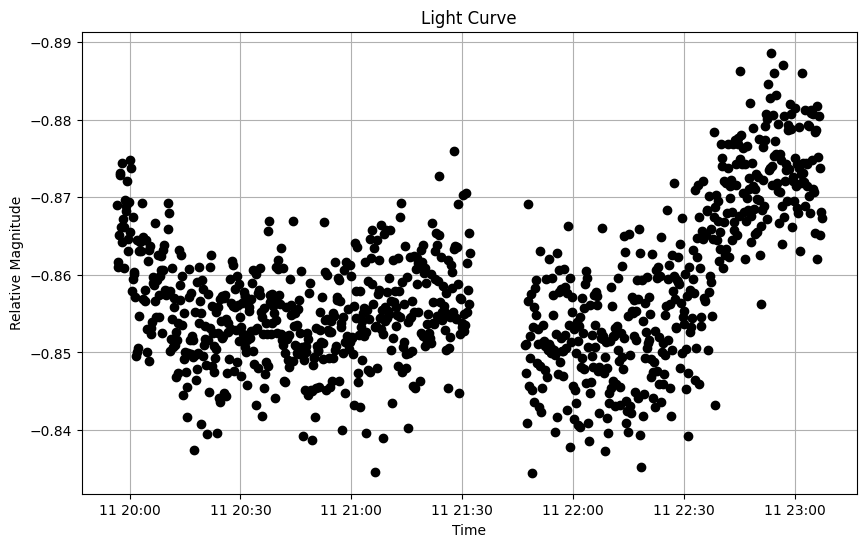

In [95]:
# 光度曲線のプロット
fig = plt.figure(figsize=(10, 6))
# plt.errorbar(times, rel_mags, yerr=errors, fmt='o', ecolor='gray', capsize=3)
plt.plot(times, rel_mags, 'o', color='black')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Relative Magnitude')
plt.title('Light Curve')
plt.grid(True)
plt.show()
fig.savefig('light_curve_toi1516_4.png')

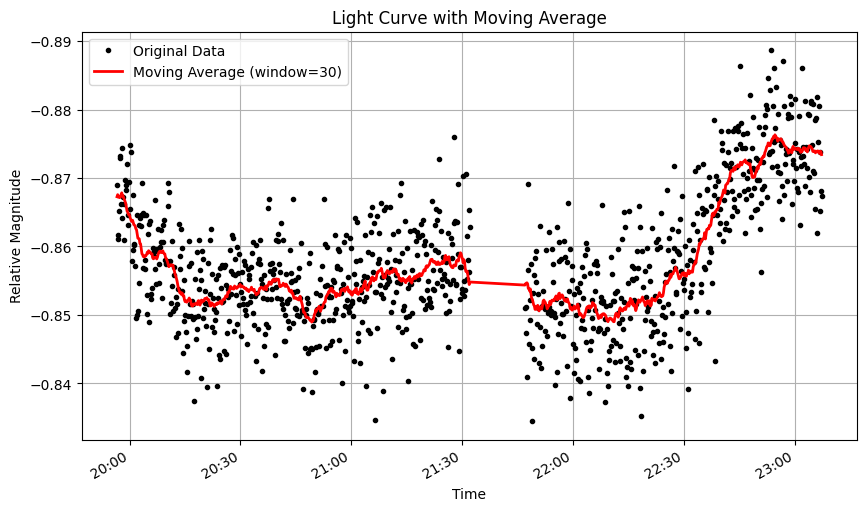

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

times_jst_naive = [dt.replace(tzinfo=None) if dt is not None and not isinstance(dt, float) else dt for dt in times]

# データをDataFrameに変換
df = pd.DataFrame({
    'Time': times_jst_naive,
    'Relative_Magnitude': rel_mags
})

# 'Time'をDatetimeIndexに設定
df.set_index('Time', inplace=True)

# 移動平均を計算
window_size = 30
df['Moving_Average'] = df['Relative_Magnitude'].rolling(window=window_size, center=True, min_periods=1).mean()
time_array = df.index.to_numpy()
moving_average_array = df['Moving_Average'].to_numpy()


# 光度曲線のプロット
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(time_array, df['Relative_Magnitude'], 'o', color='black', markersize=3, label='Original Data')
ax.plot(time_array, moving_average_array, '-', color='red', linewidth=2, label=f'Moving Average (window={window_size})')
ax.invert_yaxis()

ax.set_xlabel('Time')
ax.set_ylabel('Relative Magnitude')
ax.set_title('Light Curve with Moving Average')
ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()
plt.show()

fig.savefig('light_curve_toi1516_with_moving_average_4.png')


C:\Users\ohrtt\AppData\Local\Temp\ipykernel_14112\2505627296.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(times, moving_avg-moving_avg[0], '-', label=f'Moving Average {i+1}', color=colors[i])


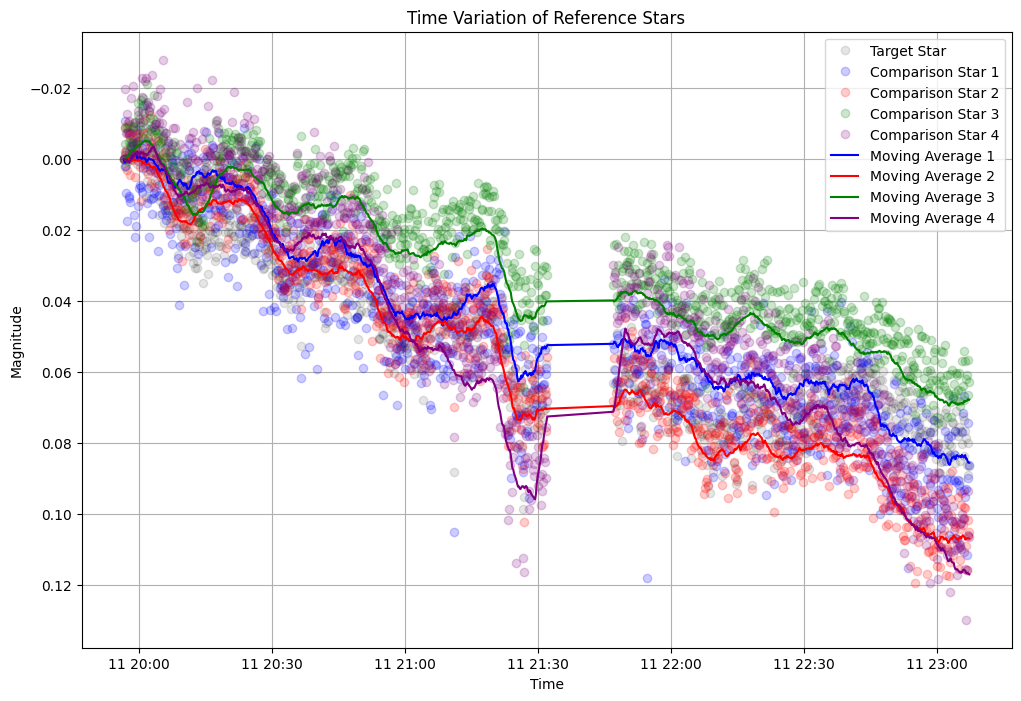

In [108]:
# 参照星の機械等級を計算
comp_mags_list = []
for fluxes in comp_fluxes_list:
    fluxes = np.array(fluxes)
    fluxes[fluxes <= 0] = 1e-10  # fluxがゼロまたは負の場合を避ける
    mags = -2.5 * np.log10(fluxes)
    comp_mags_list.append(mags)

window_size = 30

moving_avg_list = []
for mags in comp_mags_list:
    df = pd.DataFrame({
        'Time': times_jst_naive,
        'Magnitude': mags
    })
    df.set_index('Time', inplace=True)
    moving_avg = df['Magnitude'].rolling(window=window_size, center=True, min_periods=1).mean()
    moving_avg_list.append(moving_avg)

target_mags_ma = []
for mags in target_mags:
    df = pd.DataFrame({
        'Time': times_jst_naive,
        'Magnitude': mags
    })
    df.set_index('Time', inplace=True)
    moving_avg = df['Magnitude'].rolling(window=window_size, center=True, min_periods=1).mean()
    target_mags_ma.append(moving_avg)

fig = plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green', 'purple']

plt.plot(times, target_mags-target_mags[0], 'o', label='Target Star', alpha=0.1, color='black')
# plt.plot(times, target_mags_ma-target_mags_ma[0], '-', label='Target Star Moving Average', color='black')
for i, mags in enumerate(comp_mags_list):
    plt.plot(times, mags-mags[0], 'o', label=f'Comparison Star {i+1}', alpha=0.2, color=colors[i])
for i, moving_avg in enumerate(moving_avg_list):
    plt.plot(times, moving_avg-moving_avg[0], '-', label=f'Moving Average {i+1}', color=colors[i])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Time Variation of Reference Stars')
plt.legend()
plt.grid(True)
plt.show()
fig.savefig('light_curve_comp.png')


In [98]:
moving_average_array

array([-0.86726552, -0.8675672 , -0.86730585, -0.8671571 , -0.86727392,
       -0.86718679, -0.86755299, -0.86783452, -0.86740425, -0.86740677,
       -0.86708773, -0.86682702, -0.86657976, -0.86624414, -0.86567   ,
       -0.86514776, -0.86499933, -0.86465073, -0.8646985 , -0.86435173,
       -0.86406164, -0.86377307, -0.86366878, -0.8638383 , -0.86352093,
       -0.86317672, -0.86312068, -0.86297949, -0.86259254, -0.86244566,
       -0.8618405 , -0.8612034 , -0.86115961, -0.86111287, -0.86043179,
       -0.86036991, -0.85962027, -0.85893304, -0.85880066, -0.85851861,
       -0.85852953, -0.85847378, -0.8586933 , -0.85867671, -0.85884264,
       -0.85916231, -0.85898762, -0.85938718, -0.85919792, -0.85919387,
       -0.85905006, -0.85891931, -0.85889783, -0.85833725, -0.85819367,
       -0.85840528, -0.85838273, -0.85842748, -0.85841335, -0.85817662,
       -0.85843813, -0.85887077, -0.85911768, -0.85927659, -0.85931864,
       -0.85912514, -0.85910291, -0.85914095, -0.85937053, -0.85

In [99]:
comp_mags_list

[array([-11.74254775, -11.75328581, -11.74051165, -11.73309927,
        -11.72516301, -11.74276945, -11.73220895, -11.731547  ,
        -11.73042949, -11.74584506, -11.74431542, -11.7436852 ,
        -11.74647428, -11.7269361 , -11.72046638, -11.72358909,
        -11.75066637, -11.72940047, -11.74752401, -11.73433881,
        -11.73526437, -11.73456465, -11.74563948, -11.73326184,
        -11.7399876 , -11.75778149, -11.74125214, -11.74443618,
        -11.74764815, -11.73006429, -11.73450341, -11.72068832,
        -11.75099658, -11.74047808, -11.73139645, -11.72696477,
        -11.73146405, -11.73301103, -11.73884663, -11.746021  ,
        -11.73348631, -11.74280521, -11.7166928 , -11.73252757,
        -11.73511876, -11.73995248, -11.74168351, -11.72702618,
        -11.74890583, -11.72950474, -11.73191951, -11.72829562,
        -11.7253746 , -11.72669133, -11.73513049, -11.74695375,
        -11.73928545, -11.72134467, -11.74282674, -11.71873384,
        -11.74165415, -11.73047574, -11.